
# PyRADISE
Author: Sondre Vik Furuseth  
Last update: 2019.07.24

In [33]:
%reset -f
import numpy as np
import sys, time, copy,os
sys.path.append('../')
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pkl
import scipy.constants as const

# PySSD
import seaborn as sns
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
# from PySSD.Dispersion import Dispersion
from PySSD.Integrator import Integrator #FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator



# PyRADISE
import PyRADISE 
from PyRADISE.Detuning import LinearDetuningClass 
from PyRADISE.Noise    import NoiseClass
from PyRADISE.Machine  import MachineClass
from PyRADISE.Grid     import Grid1DClass,Grid2DClass
from PyRADISE.Solver   import SolverClass
from PyRADISE.StabilityDiagram import calc_Stability_Diagram
from PyRADISE.Coefficients import DiffCoeffGrid , calc_LandauDampedAllModes, calc_LandauDampedOneMode
from PyRADISE.PySSDHelper  import get_tune_range,get_tune_range_focused, findQs

# Plotting preparation
from plot_configuration import *
np.set_printoptions(precision=3,suppress=False) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

In [34]:
%matplotlib notebook
pi2 = np.pi*2

## 0 - Initialisation

In [3]:
emittnorm = 2e-6
energy = 6500*1000
gamma = energy/const.value("proton mass energy equivalent in MeV")
beta = np.sqrt(1-1/gamma**2)
emittgeo = emittnorm/(beta*gamma)
print(emittgeo/1e-12)
print(364/520)
Iocts= np.arange(5)*100
Iocts=550
axs = 520*Iocts*emittgeo
print(axs)

288.6991049462432
0.7
8.256794401462557e-05


In [4]:
# Mode 0
dw = pi2*(-2.2e-4 + 1j*3.59e-5)
absdw=abs(dw)
eta= 0.937
a_thresh = 9.64e-5
a=1.5*a_thresh
sigma_k = 5e-5
R_D = 1
imdW = (R_D*a*eta*sigma_k*absdw)**0.4
print('Im(Ω)_min=%.2e -> Im(Q)_min=%.2e  vs dQ_margin=%.2e'%(imdW,imdW/pi2,(a-a_thresh)/a_thresh*dw.imag/pi2))
print(imdW**2.5/(a*eta*sigma_k),a*eta*sigma_k*absdw)

# Mode 1
dw = pi2*(-8.43e-05+4.27e-06j)
absdw=abs(dw)
eta= 0.0247
a_thresh = 2.43e-5
a=2*a_thresh
sigma_k = 1e-3
R_D = 1
imdW = (R_D*a*eta*sigma_k*absdw)**0.4
print('Im(Ω)_min=%.2e -> Im(Q)_min=%.2e  vs dQ_margin=%.2e'%(imdW,imdW/pi2,(a-a_thresh)/a_thresh*dw.imag/pi2))
print(imdW**2.5/(a*eta*sigma_k),a*eta*sigma_k*absdw)

# Mode LHC
dw = pi2*(-5e-05+5e-06j)
absdw=abs(dw)
eta= 0.05
a_thresh = 5e-5
a=1.4*a_thresh
sigma_k = 2e-5
R_D = 1
imdW = (R_D*a*eta*sigma_k*absdw)**0.4
print('Im(Ω)_min=%.2e -> Im(Q)_min=%.2e  vs dQ_margin=%.2e'%(imdW,imdW/pi2,(a-a_thresh)/a_thresh*dw.imag/pi2))
print('tau_h = %.2e'%(1/np.sqrt(a*eta*sigma_k)))
print(imdW**2.5/(a*eta*sigma_k),a*eta*sigma_k*absdw)


Im(Ω)_min=3.90e-05 -> Im(Q)_min=6.20e-06  vs dQ_margin=1.79e-05
0.0014005840179880556 9.488270435700276e-12
Im(Ω)_min=1.32e-05 -> Im(Q)_min=2.11e-06  vs dQ_margin=4.27e-06
0.000530351568265361 6.366446295771055e-13
Im(Ω)_min=3.45e-06 -> Im(Q)_min=5.49e-07  vs dQ_margin=2.00e-06
tau_h = 1.20e+05
0.00031572615420804494 2.2100830794563184e-14


In [92]:
######################################
####### Calculation parameters #######
alpha = 1             # alpha = 0: direct from Lebedev, alpha=1: cancel drift term
iCoeff  = 3            # Which diffusion coefficient [0, constant (r), LL (r),NEW, NEW+LL ...,[10],constant (J),K*LL(J)]
bool_FVM = 1          # true: use FVM, false: use FDM  (only implemented FVM)
bool_radial = 1       # true: radial PDE, false: action PDE
bool_adjustGrid = 0   # true: shift grid so that one cell is centered on the zero
BC_xMax = 0           # i = [Dirichlet Psi=0, Neumann djPsi=0, Robin: djPsi+Psi=0 or drPsi+rPsi=0, dPsi const]
BC_xVal = 0
bool_IC_point = 0     # IC given as point value or average for cell
flag_ProjX = 0        # true: Calculate projection on x and y axis (time consuming and rarely interesting)
solve_method=['RK45','RK23','Radau','BDF','LSODA'][3]
flag_adjustTmax = 0   # Calculate approximately how long the latency will be to set tmax
flag_dpsidt = 0       # 1 (0): Recalculate Diffusion coeffiecent every step
flagUpdateReQ = 0    # 1 (0): Update Real(dQ_LD) every step or not
flagFindalpha = [1,1]

pi2 = 2*np.pi

# calc_ax5.00e-05_bx:ax-0.00_gx0e+00_BC0_1D_Kx1.0e-03_Ky0.0e+00_iC3_reDQx3.0e-05_imDQx4.0e-05_Nc420_tmax250h
# calc_ax5.00e-05_bx-ax0.00_gx1e-02_BC0_1D_Kx5.0e-04_Ky0.0e+00_Ix0.0e+00_Iy0.0e+00_Nc700r_tmax100h
## Time Iteration Parameters
f_rev =  1 # 11.2455e3
nturns = [37.5e6,100e6][alpha]     # 100e6 for comparison to COMBIp, 37.5 for comparison to easy incoherent noise
nturns = 100e6 *10
nturns = f_rev * 3600 * [100 , 1/60 ][iCoeff>2] 
nturns = f_rev * 60 * 10
# nturns = f_rev * 1000 # .07
# nturns = f_rev * 60
nturns = 20000
time_scale='auto'

tmax = nturns/f_rev
ntODE = 101
ntODE = 600
ntODE = 3
tsODE = np.linspace(0,tmax,ntODE)
ntPSImax = 41  # overruled by indexSD

## Define grid 
ND = 1
Ncx = 500
Ncy = Ncx
rxMax = np.sqrt(2*20)
ryMax = rxMax
JxMax = rxMax**2/2 
JyMax = ryMax**2/2 

#######################################
## Default Beam & Machine parameters ##
Qx = 0.31
Qy = 0.32
Qs = 0.002
sigma_dpp = 1e-4
Qpx= 0
Qpy= 0
gx = gy = 0
a_thresh = 1e-4

#####################
## Wake parameters ##
study = 0

wmodeQ0y=[]       ; wmode__DQy=[]         ; wmodeDipmy=[]
if study ==0:
    # Free testing
    wmode__DQx = [-1.4e-4+1j*2e-5]
    wmode__DQx = [-1e-4+1j*1.0e-5]
    wmode__DQx = [-2.2e-4 + 1j*3.59e-5]
    # wmode__DQx = [-4e-4+1j*1.177e-5]  # Test
    wmodeDipmx = [[5e-3,1,1e-2,0][0]]
    wmodeQ0x   = [Qx+0*Qs]
    
    wmode__DQx = [-1e-4+1j*1.e-5]
    a_thresh = 5e-5
    gx=gy=0.1

    
elif study ==1:
    #Mode 0
    wmode__DQx = [-2.2e-4 + 1j*3.59e-5]
    wmodeDipmx = [1 ]
    wmodeQ0x   = [Qx]

    a_thresh = 9.64e-5
    Qpx = -5
    sigma_dpp = 1.129e-4
    
elif study ==2:
    # Mode 1
    # 1. mode: 0*Qs, -8.42630653e-05+4.26645271e-06j, 0.02467763 , a_thresh=2.43e-5
    # 2. mode: 1*Qs, -6.45560213e-05+1.44627487e-06j, 0.04493513 , a_thresh=1.5e-5
    # 3. mode:-3*Qs, -4.02684229e-05+2.20672406e-06j, 0.02180443 , a_thresh=1.2e-5
    wmode__DQx = [-8.43e-05+4.27e-06j]
    wmodeDipmx = [0.0247]
    wmodeQ0x   = [Qx]

    a_thresh = 2.43e-5
    Qpx = 15
    Qs = 0.0019
    gx=0.02
    sigma_dpp = 1.017e-4

elif study==3:
    # Test impact of having two modes
    wmode__DQx = [-2.2e-4 + 1j*3.59e-5, (-2.2e-4 + 1j*3.59e-5) + (1+.2j)*1e-4]
    wmodeDipmx = [1 ,1 ]
    wmodeQ0x   = [Qx,Qx]
    
if ND==1 :
    # 1D test
#     wmode__DQx = [2e-5+1j*3e-5]

    a_thresh = 1.e-5*3
    wmode__DQx = [2*a_thresh+0j]
    wmode__DQx = [0+3e-4j/(4*np.pi)]
    wmodeDipmx = [1]
    wmodeQ0x   = [Qx]
    
#     wmodeLdDQx= [2*a_thresh-0.12j*a_thresh]
    Qpx=0
    gx=0
    
#######################################
## Update Beam & Machine parameters ##
ax = a_thresh * 1.
bx = -ax * 0.70 *0   # [190/260,0.70,1][1]   #bx = -1*ax -> big problems! #0.70255
ay = ax
by = bx



######################
## Noise parameters ##

#  Lebedev noise  
# sigma_kx = 3e-3 /np.sqrt(3) 
sigma_kx = [5e-4 , 5e-5][iCoeff>=3]
if study ==0:
    sigma_kx = 1e-3
elif study==1:
    sigma_kx = 5e-5
elif study ==2:
    sigma_kx = 1e-4
    
if ND==1 :
    delta_n = 0.987262819424233e-3
    bx=by=0
    sigma_kx = delta_n/(2*pi2*np.abs(wmode__DQx[0])*wmodeDipmx[0]) 
    
    sigma_kx = 3e-4/np.sqrt(1e5)
    
sigma_ky = sigma_kx*0
JAvg  = 1
dQxAvg = (ax+bx*(ND>1))*JAvg
dQyAvg = (ay+by*(ND>1))*JAvg

# IBS noise
sigma_ibsx = np.sqrt(0.02*2/f_rev/3600)
sigma_ibsx= 0
sigma_ibsy = sigma_ibsx*0

# Harmonic excitation noise  #temp for harmonic excitation
Ah     = 0  
Jh     = 1
dQh    = ax*Jh






if 0:
    #mode 1
    ax = 5e-5
#     ax = 1e-4
    bx = -0.7*ax
    bx = 0
    ay=ax ; by=bx
    gx=gy=0.01
    
    sigma_kx = 5e-4
#     sigma_kx = 1e-4
    sigma_ky = sigma_kx * 0
    sigma_ibsx = sigma_ibsy = 0
#     sigma_ibsx = np.sqrt(0.02*2/f_rev/3600)
#     sigma_ibsy = sigma_ibsx
    wmode__DQx = [[-1e-4+1j*1.2e-5 , -2.2e-4 + 1j*3.59e-5][0]]
    wmodeDipmx = [[1e-2,1][0]]
    wmodeQ0x=[]       ; wmode__DQx=[]         ; wmodeDipmx=[]
    wmodeQ0y=[]       ; wmode__DQy=[]         ; wmodeDipmy=[]
    flag_adjustTmax = 0   # Calculate approximately how long the latency will be to set tmax
    flag_dpsidt = 0       # 1 (0): Recalculate Diffusion coeffiecent every step
    flagUpdateReQ = 0     # 1 (0): Update Real(dQ_LD) every step or not
    flagFindalpha = [0,0]

#     wmodeQ0y=[Qy+0] ; wmode__DQy=wmode__DQx ; wmodeDipmy=wmodeDipmx



# D0  = sigma_k**2*f_rev / (2 )#+ 2*bool_radial) # need a second '/2' if operating with r
# Dibs= sigma_ibs**2*f_rev / (2 )#+ 2*bool_radial) # need a second '/2' if operating with r

ImOmega = 1e-5
print('Sideband parameter: (%.1e, %.1e)'%(Qpx*sigma_dpp/Qs,Qpy*sigma_dpp/Qs))
print('kappa_wake (ImOmega=%.1e) = %.2e'%(ImOmega,wmodeDipmx[0]*sigma_kx*np.abs(wmode__DQx[0])/(1e-6)**1.5))
print('diffusion peak width = ImOmega/2pi a = %.3e'%(ImOmega/(2*np.pi*ax)))

##################################################
## Parameters for Stability diagram Calculation ##
nQ = [40,300][Ncx>400] #100
interp_order = 1
debug        = 0
integrator_epsilon = 1e-6 * ax/5e-5  *[1,2][1*(np.abs((bx**2+ax**2)/(bx*ax+1e-16))<0.1)] 


nSD_scaled = [80,0][iCoeff>2] #31                          # How many scaled detuning strengths to calc SD for
scales = np.linspace(1.2,.001,nSD_scaled,)  # Which scales
ntSDmax = ntPSImax
dtSD = int(np.ceil(ntODE/ntSDmax))
indexSD = np.arange(0,ntODE,dtSD)               # What values of tsODE to calculate SD for 
# ntSD = np.size(indexSD)


######################################
######## Plotting parameters #########


nplots=100           # nplots: max number of curves from psis
plot_step = int(np.ceil(np.size(tsODE)/nplots))
print('nt=%d , nplots=%d -> plot_step=%d'%(ntODE,nplots,plot_step))

plot_rmax    = 4
flag_fill    = 1
flag_fillSD  = 1
flag_savefig = 1
flag_JdPsidJ = 1

# flag_SD_constituents=0   


##########################################
## Store parameters in relevant objects ##

detuning = LinearDetuningClass(Qx,Qy,ax,bx,ay,by)
noise = NoiseClass(f_rev,sigma_kx,dQxAvg,sigma_ky,dQyAvg,alpha,
                         sigma_ibsx,sigma_ibsy,
                         Ah,dQh,0,-1)
mach = MachineClass(detuning,noise,gx,gy,f_rev,
                    wmodeQ0x,wmode__DQx,wmodeDipmx,
                    wmodeQ0y,wmode__DQy,wmodeDipmy,
                    Qpx=Qpx,Qpy=Qpy,Qs=Qs,sigma_dpp=sigma_dpp)
                    
if ND == 1:
#     grid = Grid1DClass(Ncx,JxMax,BC_xMax,BC_xVal,bool_radial,bool_adjustGrid,JAvg)
    grid = Grid2DClass(Ncx,JxMax,BC_xMax,BC_xVal,bool_radial)
else:
    grid = Grid2DClass(Ncx,JxMax,BC_xMax,BC_xVal,bool_radial,
                       Ncy,JyMax,BC_xMax,BC_xVal)
calc = SolverClass(grid,mach,iCoeff,tsODE,ntPSImax,bool_IC_point,
                  interp_order=interp_order,integrator_epsilon=integrator_epsilon,solve_method=solve_method,
                  flagFindalpha=flagFindalpha, flagUpdateReQ=flagUpdateReQ ,
                  flag_dpsidt=flag_dpsidt,flag_adjustTmax=flag_adjustTmax)

###########################
## Initialize PDE Solver ##
# calc.initSolver()

##############################
## Initialize SD Calculator ##
calc.initSD(indexSD=indexSD,scales=scales,nQ=nQ,integrator_epsilon=integrator_epsilon,
            interp_order=interp_order,debug=debug)

########################
## Initialize plotter ##
calc.initPlotting(time_scale,plot_rmax,flag_fill,plot_step,figwidth,figheight)


 
if ND==1 and 0 :
    calc.M.flag_wmode=False
    calc.M.wmodeLdDQx = wmodeLdDQx
    calc.calc_Coeff(psi=calc.psi0)
#     calc.M.flag_wmode=True
    calc.calc_FV_M()
    calc.calc_BC_V()
#############
## Storage ##
pltstorage = '04_Plots_Diffusion/'
pklstorage = '01_Output/'


tlabel=calc.tlabel
tunit =calc.tunit
time_scale=calc.time_scale
filename = 'calc_test'
filename = 'calc_ax%.2e_bx:ax%.2f_gx%.0e_BC%d_%dD_Nc%d'%(ax,bx/ax,gx,BC_xMax,ND,Ncx)
filename = 'calc_ax%.2e_bx:ax%.2f_gx%.0e_BC%d_%dD_Kx%.1e_Ky%.1e_Ix%.1e_Iy%.1e_Nc%d%s_tmax%d%s'%(
                ax,bx/ax*(ND>1),gx,BC_xMax,ND,sigma_kx,sigma_ky*(ND>1),sigma_ibsx,sigma_ibsy*(ND>1),Ncx,
                ['J','r'][bool_radial],tmax/time_scale,tunit[0])
if iCoeff>=3:
    filename = 'calc_D%s_ax%.2e_bx:ax%.2f_gx%.0e_BC%d_%dD_Kx%.1e_Ky%.1e_ibs%.0e-%.0e_iC%d_reDQx%.1e_imDQx%.1e_finda%d%d%d_Nc%d%s_tmax%s'%(
                     ['0','t'][flag_dpsidt],ax,bx/ax*(ND>1),gx,BC_xMax,ND,sigma_kx,sigma_ky*(ND>1),sigma_ibsx,sigma_ibsy,iCoeff,wmode__DQx[0].real,wmode__DQx[0].imag,
                     flagFindalpha[0],flagFindalpha[1],flagUpdateReQ,Ncx,['J','r'][bool_radial],['%d%s'%(tmax/time_scale,tunit[0]),'X'][flag_adjustTmax])
    


# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_aKconst_a|a0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_a|a0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_g|Kconst_g0|g=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_g0|g=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_K|K0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_b|a0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        bfac[scannr])
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_rel(Kx,Ky)=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        (noisefac1[scannr]-noisefac2[scannr])/(noisefac1[scannr]+noisefac2[scannr]))
# filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_Kxconst_rel(Kx,10Ix)=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        (noisefac1[scannr]-noisefac2[scannr])/(noisefac1[scannr]+noisefac2[scannr]))

# filename = 'NEWscan_mode0_D%s_ax%.2e_bx|ax%.2f_gx%.0e_Kx%.1e_Ky%.1e_ibs%.0e-%.0e_iC%d_Nc%d%s_tmax%d%s'%(
#                      ['0','t'][flag_dpsidt],ax,bx/ax*(ND>1),gx,sigma_kx,sigma_ky*(ND>1),sigma_ibsx,sigma_ibsy,iCoeff,
#                      Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0])
print(filename+'_S0.pkl')
flag_save_pkl = True
flag_load_pkl = flag_save_pkl



################
## Store calc ##
if flag_save_pkl:
    with open(pklstorage+filename+'_S0.pkl','wb') as pklfile:
        pkl.dump(calc,pklfile)


Sideband parameter: (0.0e+00, 0.0e+00)
kappa_wake (ImOmega=1.0e-05) = 2.26e-02
diffusion peak width = ImOmega/2pi a = 5.305e-02
nt=3 , nplots=100 -> plot_step=1
stencil 2D
BC 2D
Found alpha!=1, alpha=1.40e+00 -5.21e-01j |  dampDQ = 4.04e-05 -3.389e-06j -> 3.86e-05 -4.728e-06j
calc_LandauDampedAllModes: Mode: 0.00e+00 +2.39e-05i -> 3.86e-05 -4.728e-06i (relerr(10 iterations)=3.2e-05)
calc_D0_ax3.00e-05_bx:ax0.00_gx0e+00_BC0_1D_Kx9.5e-07_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx0.0e+00_imDQx2.4e-05_finda110_Nc500r_tmax5h_S0.pkl


0.31
2.38732414637843e-05j
(3.8649581374195275e-05-4.7283888000563365e-06j) (1.2883193791398424-0.15761296000187786j)


<IPython.core.display.Javascript object>


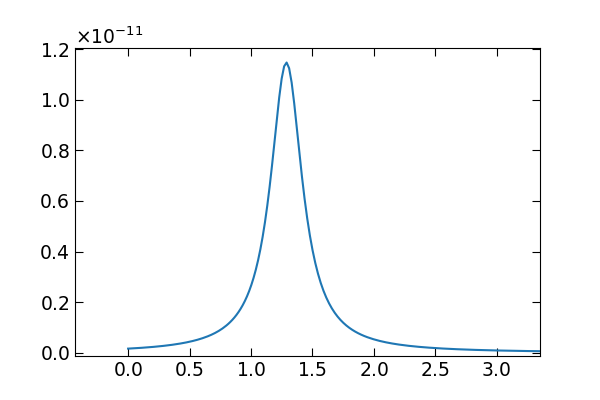

20000.0 20000


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [93]:

# calc_LandauDampedAllModes(calc,debug=1)
print(calc.M.wmodeQ0x[0])
print(calc.M.wmode__DQx[0])
print(calc.M.wmodeLdDQx[0],calc.M.wmodeLdDQx[0]/calc.M.Q.ax)

## Plot Diffusion coefficients
if ND==1:
    DDx,_,err=DiffCoeffGrid(calc.M, calc.G,iCoeff)
    plt.figure()
    plt.plot(calc.G.Jxbx,DDx[0]/calc.G.X[0])#/calc.G.Jxc1D)
else:
    out=calc.plot_Coeff2D(iCoeffType=0,plane=0,vlmax=1e-4,nDec=3)
    out=calc.plot_Coeff2D(iCoeffType=0,plane=1,vlmax=1e-5,nDec=3)
    
print(tmax,nturns)

In [4]:
ImQ = calc.M.wmodeLdDQx[0].imag
delta_n = 2*calc.M.N.sigma_kx * np.abs(pi2*calc.M.wmode__DQx[0]) * calc.M.wmodeDipmx[0]
R_D = (-pi2*ImQ)**2.5/(delta_n/2*calc.M.Q.ax0)
print('R_D = %.2e >>1'%(R_D))
time_amp2 = calc.tsODE*calc.time_scale*calc.M.f_rev*delta_n**2/4
print(time_amp2)

R_D = 1.00e+00 >>1
[0.    0.    0.001 0.001 0.002 0.002 0.002 0.003 0.003 0.004 0.004 0.005
 0.005 0.005 0.006 0.006 0.007 0.007 0.007 0.008]


NEWscan_mode0_Dt_ax1.06e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax0s_S0.pkl
NEWscan_mode0_Dt_ax1.16e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax0s_S0.pkl
NEWscan_mode0_Dt_ax1.25e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax0s_S0.pkl
NEWscan_mode0_Dt_ax1.35e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax2s_S0.pkl
NEWscan_mode0_Dt_ax1.45e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax5s_S0.pkl
NEWscan_mode0_Dt_ax1.54e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax10s_S0.pkl
NEWscan_mode0_Dt_ax1.64e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax20s_S0.pkl
NEWscan_mode0_Dt_ax1.74e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax50s_S0.pkl
NEWscan_mode0_Dt_ax1.83e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax90s_S0.pkl
NEWscan_mode0_Dt_ax1.93e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax150s_S0.pkl

In [50]:
filenames=["calc_Dt_ax2.00e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax11m_S0.pkl",
           "calc_Dt_ax1.20e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax5s_S0.pkl",
           "calc_Dt_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax20s_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx1e-01_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC4_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx1e-01_BC0_2D_Kx5.0e-04_Ky5.0e-04_ibs0e+00-0e+00_iC4_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky5.0e-04_ibs0e+00-0e+00_iC3_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs3e-05-3e-05_iC3_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs3e-05-0e+00_iC3_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl",
           "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.0e-04_imDQx1.0e-05_Nc700r_tmax10m_S0.pkl"]

filenames = ["NEWscan_mode0_Dt_ax1.06e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax0s_S0.pkl",
"NEWscan_mode0_Dt_ax1.16e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax0s_S0.pkl",
"NEWscan_mode0_Dt_ax1.25e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax0s_S0.pkl",
"NEWscan_mode0_Dt_ax1.35e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax2s_S0.pkl",
"NEWscan_mode0_Dt_ax1.45e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax5s_S0.pkl",
"NEWscan_mode0_Dt_ax1.54e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax10s_S0.pkl",
"NEWscan_mode0_Dt_ax1.64e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax20s_S0.pkl",
"NEWscan_mode0_Dt_ax1.74e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax50s_S0.pkl",
"NEWscan_mode0_Dt_ax1.83e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax90s_S0.pkl",
"NEWscan_mode0_Dt_ax1.93e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax150s_S0.pkl"]

for scannr in range(11):
    #aKconst_
#     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_a|a0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# #     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_aKconst_a|a0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
# #                                                        logfac[scannr])
#     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_g0|g=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
# #     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_g|Kconst_g0|g=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
# #                                                        logfac[scannr])
#     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_K|K0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        logfac[scannr])
#     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_b|a0=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        bfac[scannr])
# #     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_rel(Kx,Ky)=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
# #                                                        (noisefac1[scannr]-noisefac2[scannr])/(noisefac1[scannr]+noisefac2[scannr]))
#     filename = 'lebscan_%dD_Nc%d%s_tmax%d%s_Kxconst_rel(Kx,10Ix)=%.2e'%(ND,Ncx,['J','r'][bool_radial],tmax/time_scale,tunit[0],
#                                                        (noisefac1[scannr]-noisefac2[scannr])/(noisefac1[scannr]+noisefac2[scannr]))
    ax = a_thresh*(1.0 +0.05*(scannr==0)+scannr/10)
    bx = -ax*.7
    filename = 'calc_D%s_ax%.2e_bx:ax%.2f_gx%.0e_BC%d_%dD_Kx%.1e_Ky%.1e_ibs%.0e-%.0e_iC%d_reDQx%.1e_imDQx%.1e_finda%d%d%d_Nc%d%s_tmax%s'%(
                     ['0','t'][flag_dpsidt],ax,bx/ax*(ND>1),gx,BC_xMax,ND,sigma_kx,sigma_ky*(ND>1),sigma_ibsx,sigma_ibsy,iCoeff,wmode__DQx[0].real,wmode__DQx[0].imag,
                     flagFindalpha[0],flagFindalpha[1],flagUpdateReQ,Ncx,['J','r'][bool_radial],['%d%s'%(tmax/time_scale,tunit[0]),'X'][flag_adjustTmax])
#     filename = filenames[scannr]
    # _g|Kconst
    nametype=2
    if nametype==1:
        print("%s_S0.pkl"%filename)
    elif nametype==2:
        print("arguments=\"%s_S0.pkl\" \nqueue"%filename)
#         print("arguments=\"%s\" \nqueue"%filename)
    elif nametype==3:
        print("\"%s_S2.pkl\","%filename)
    

arguments="calc_Dt_ax2.55e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.4e-05_imDQx4.3e-06_finda110_Nc700r_tmaxX_S0.pkl" 
queue
arguments="calc_Dt_ax2.67e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.4e-05_imDQx4.3e-06_finda110_Nc700r_tmaxX_S0.pkl" 
queue
arguments="calc_Dt_ax2.92e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.4e-05_imDQx4.3e-06_finda110_Nc700r_tmaxX_S0.pkl" 
queue
arguments="calc_Dt_ax3.16e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.4e-05_imDQx4.3e-06_finda110_Nc700r_tmaxX_S0.pkl" 
queue
arguments="calc_Dt_ax3.40e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.4e-05_imDQx4.3e-06_finda110_Nc700r_tmaxX_S0.pkl" 
queue
arguments="calc_Dt_ax3.65e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-8.4e-05_imDQx4.3e-06_finda110_Nc700r_tmaxX_S0.pkl" 
queue
arguments="calc_Dt_ax3.89e-05_bx:ax-0.70_gx2e-

In [7]:
calc.tsSD = calc.tsODE[calc.indexSD]
print(calc.tsSD)
print(calc.growthRatex)
print(calc.nt,calc.tsODE,calc.ts)
self=calc
self.calc_InterpDist(self.psis[-1],0)
distribution=self.interpDistx
detuning = self.M.Q 
integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
calc_LandauDampedOneMode(self,integrator,0.31,wmode__DQx[0],relstep=[.5,.05],tol=1e-4,debug=1)


[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50.]


AttributeError: 'SolverClass' object has no attribute 'growthRatex'

In [39]:
out=calc.plot_Coeff1D(iCoeffType=0,plane=0,indexY=300)
out[0].tight_layout()
print(calc.G.Jxbx2D[0,:])

IndexError: index 300 is out of bounds for axis 0 with size 1

In [8]:
# tempname = "calc_Dt_ax5.00e-05_bx:ax-0.70_gx1e-01_BC0_2D_Kx5.0e-04_Ky5.0e-04_ibs0e+00-0e+00_iC4_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m_S0.pkl"
# with open(pklstorage+tempname,'rb') as pklfile:
#     calc = pkl.load(pklfile)


## 1 - Solving the PDE

In [37]:
# filename = 'lebscan_2D_Nc700r_tmax24h_K|K0=4.00e+00'

###############
## Load calc ##
if flag_load_pkl:
    with open(pklstorage+filename+'_S0.pkl','rb') as pklfile:
        calc = pkl.load(pklfile)

###########################
## Solve PDE numerically ##
# flag_dpsidt=     1# flag_dpsidt
# flag_adjustTmax= 1# flag_adjustTmax
# flagUpdateReQ = 0
# flagFindalpha = [1,0]

calc.integrator_epsilon = integrator_epsilon*1
psis = calc.solve()
# psis = calc.solve(solve_method=['RK45','RK23','Radau','BDF','LSODA'][3],
#                   flag_dpsidt=flag_dpsidt,flag_adjustTmax=flag_adjustTmax,debug=0,
#                   flagFindalpha=flagFindalpha,flagUpdateReQ=flagUpdateReQ)#,relstep=[.5,.1])  # LSODA if iCoeff==3, else BDF


#####################
## Post Processing ##
calc.postProc_Distributions(flag_ProjX=flag_ProjX)
calc.postProc_Moments(n_moments = 3)

################
## Store calc ##
if flag_save_pkl:
    with open(pklstorage+filename+'_S1.pkl','wb') as pklfile:
        pkl.dump(calc,pklfile)
        
print(filename)


Solver.py: Solve diffusion equation.

Found alpha!=1, alpha=1.40e+00 -5.21e-01j |  dampDQ = 1.35e-04 -1.130e-05j -> 1.29e-04 -1.577e-05j
calc_LandauDampedAllModes: Mode: 0.00e+00 +7.96e-05i -> 1.29e-04 -1.577e-05i (relerr(10 iterations)=3.2e-05)
Found alpha!=1, alpha=1.40e+00 -5.21e-01j |  dampDQ = 1.35e-04 -1.130e-05j -> 1.29e-04 -1.576e-05j
SD_calcGrowthRate (0.00 s): Mode: 0.00e+00 +7.96e-05i -> 1.29e-04 -1.58e-05i (relerr(10 iterations)=3.2e-05)
Found alpha!=1, alpha=1.40e+00 -5.21e-01j |  dampDQ = 1.35e-04 -1.130e-05j -> 1.29e-04 -1.576e-05j
SD_calcGrowthRate (0.89 s): Mode: 0.00e+00 +7.96e-05i -> 1.29e-04 -1.58e-05i (relerr(10 iterations)=3.2e-05)
Found alpha!=1, alpha=1.40e+00 -5.21e-01j |  dampDQ = 1.35e-04 -1.130e-05j -> 1.29e-04 -1.577e-05j
SD_calcGrowthRate (1.78 s): Mode: 0.00e+00 +7.96e-05i -> 1.29e-04 -1.58e-05i (relerr(10 iterations)=3.2e-05)
Solving the PDE took 17.90s
Postprocessing(Distributions) took 0.00s
calc_D0_ax1.00e-04_bx:ax0.00_gx0e+00_BC0_1D_Kx1.0e-06_Ky0.0e

In [8]:
print(calc.M.wmode__DQx[0].imag)
print(calc.flagFindalpha)
print(np.sign(-1))
integrator_epsilon

3.59e-05
[1, 0]
-1


7.23e-07

a = 1.1 a_thresh
Timestep 24: Latency (x) = 7.20e-03 sec
Timestep 24: Latency (x) = 7.21 ms

a = 1.5 a_thresh
nt = 100 (tmax=59 sec) -> Latency (x) = 8.20 sec   
nt = 200 (tmax=59 sec) -> Latency (x) = 7.27 sec   
Timestep 22 : Latency (x) = 7.26 sec
Timestep 35 : Latency (x) = 6.87 sec  
Timestep 46 : Latency (x) = 6.61 sec
Timestep 88 : Latency (x) = 6.27 sec
Need no more than 6 sidebands:  [4.658e-01 2.079e-01 4.994e-02 8.155e-03 1.007e-03 9.986e-05]

a = 2.0 a_thresh
nt = 200 (tmax = 2900 sec) -> Latency (x) = 2.86 min
Timestep 25: Latency (x) = 2.29 min
Timestep 37: Latency (x) = 2.14 min
Timestep 68: Latency (x) = 1.97 min
Timestep 86: Latency (x) = 1.92 min

In [15]:
# calc.indexSD = calc.indexPSI
# calc.indexSD = calc.indexSD[2::7]
# calc.tsSD = calc.tsODE[calc.indexSD]
# calc.ntSD = np.size(calc.indexSD)
print(calc.ntODE, calc.ntSD,calc.indexSD, calc.ntPSI)
print(calc.tsSD)
print(calc.M.N.sigma_kx)

25 3 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] 25
[0.007 0.007 0.007]
0.0001


## 2 - Calculate Stability diagrams

In [27]:
"""
SD_calcEvolution(self,planes=[0,1],interp_order=1,**kwargs):
    kwargs: nQ,indexSD,debug, integrator_epsilon
    
SD_calcScaledPsi(calc,scales,plane,interp_order,ind,**kwargs):
    ind =  >=0: With calculated distribution at t=tsSD[ind]
            <0: With Gaussian()
    kwargs: nQ, debug, integrator_epsilon
        
"""

###############
## Load calc ##
if flag_load_pkl:
    with open(pklstorage+filename+'_S1.pkl','rb') as pklfile:
        calc = pkl.load(pklfile)
        
# calc.nQ=200
# calc.indexSD = np.concatenate(([0],calc.indexSD[-2:]))
# calc.indexSD = calc.indexSD[[0,5,6,7]]
# calc.tsSD = calc.tsODE[calc.indexSD]
# calc.ntSD = np.size(calc.indexSD)

####################################################
## Calculate stability diagram evolution (from PDE solver)
calc.SD_calcEvolution(planes=[0],interp_order=interp_order,debug=1,width_ratio=[1,0.07][iCoeff>2])
    #,indexSD=indexSD,nQ=nQ,integrator_epsilon=integrator_epsilon,debug=debug,width_ratio=0.1)
    # if width_ratio<0. only show that amount of the SD

## Calculate SD with scaled detuning for psi(t=0) ##
if np.size(scales)>0:
    calc.SD_calcScaledPsi0(plane=0,interp_order=1,ind=-1,debug=0)
    calc.SD_copyScaledPsi0(planeFrom=0)

# calc.integrator_epsilon = temp



4 processes (ncpus=8)
Elapsed time calculating a stability diagram (0,x): 77.65s.
Elapsed time calculating a stability diagram (2,x): 76.54s.
Elapsed time calculating a stability diagram (3,x): 76.38s.
Elapsed time calculating a stability diagram (1,x): 79.49s.
Elapsed time calculating a stability diagram (4,x): 88.56s.
Elapsed time calculating a stability diagram (5,x): 87.88s.
Elapsed time calculating a stability diagram (6,x): 86.82s.
Elapsed time calculating a stability diagram (7,x): 89.15s.
Elapsed time calculating a stability diagram (8,x): 86.47s.
Elapsed time calculating a stability diagram (9,x): 86.23s.
Elapsed time calculating a stability diagram (10,x): 87.69s.
Elapsed time calculating a stability diagram (20,x): 90.39s.
Elapsed time calculating a stability diagram (30,x): 78.19s.
SD Evolution: 733.88s


In [28]:
#######################
## SD Postprocessing ##
if iCoeff>=3:
    modex = calc.M.wmode__DQx[0]
    modey = -1.5e-4+0j
    calc.SD_calcStabilityMargin(plane=0,mode=modex)
    # calc.SD_calcStabilityMargin(plane=1,mode=modey)

if np.size(scales)>0:
    calc.SD_calcEffectiveStrength(plane=0,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=100)
    calc.SD_calcEffectiveStrength(plane=1,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=100)

################
## Store calc ##
if flag_save_pkl:
    addname = ''
    if iCoeff==3 and 0:
        addname = '_scale%.2f'%scale 
    with open(pklstorage+filename+'_S2%s.pkl'%addname,'wb') as pklfile:
        pkl.dump(calc,pklfile)
    print(filename)

calc_D0_ax5.00e-05_bx:ax-0.70_gx1e-01_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.0e-04_imDQx1.0e-05_finda000_Nc500r_tmax10m


## 3 - Plotting

In [26]:
###############
## Load calc ##
if 1:
    
    filename = "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc180r_tmax15m"
    filename = ["calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc500r_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc500J_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc400J_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc400r_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc300r_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc300J_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc200J_tmax10m",
    "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc200r_tmax10m",
               ][7]
    filename = "calc_ax5.00e-05_bx:ax-0.70_gx1e-02_BC0_2D_Kx5.0e-04_Ky5.0e-04_Nc500"
    # filename = "calc_ax5.00e-05_bx:ax-0.70_gx1e-02_BC0_2D_Kx5.0e-04_Ky0.0e+00_Nc500"

    filename = "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc500r_tmax10m"
    filename = "lebscan_2D_Nc700r_tmax24h_a|a0=%.2e"%1.59
    filename = "calc_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc200r_tmax20s"
    # filename = "lebscan_2D_Nc700r_tmax24h_K|K0=4.00e+00"
    # filename = "lebscan_2D_Nc700r_tmax24h_b|a0=%.2e"%0
    # filename = "lebscan_2D_Nc700r_tmax24h_rel(Kx,Ky)=%.2e"%0
    # filename = "lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=-1.00e+00"
    # filename = "lebscan_2D_Nc700r_tmax24h_g0|g=%.2e"%1.59
    filename = "calc_ax1.60e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc200r_tmax100s"
    filename = "calc_Dt_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax20s"
    filename = "calc_Dt_ax1.20e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax5s"
#     filename = "calc_Dt_ax2.00e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax11m"
#     filename = "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m"
#     filename = "calc_Dt_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs3e-05-3e-05_iC3_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m"
#     filename = "calc_Dt_ax5.00e-05_bx:ax-0.70_gx1e-01_BC0_2D_Kx5.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC4_reDQx-1.0e-04_imDQx1.2e-05_Nc700r_tmax10m"
#     filename = "calc_ax5.00e-05_bx:ax-0.70_gx2e-02_BC0_2D_Kx1.7e-03_Ky1.7e-03_ibs0e+00_iC4_reDQx-8.0e-05_imDQx5.0e-06_Nc180r_tmax1m"
#     filename = "NEWscan_mode0_Dt_ax1.64e-04_bx|ax-0.70_gx0e+00_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_Nc700r_tmax20s"
#     filename = "calc_ax5.00e-05_bx:ax-0.00_gx0e+00_BC0_1D_Kx1.0e-03_Ky0.0e+00_iC3_reDQx3.0e-05_imDQx4.0e-05_Nc420_tmax250h"
#     filename = "lebscan_2D_Nc700r_tmax24h_aKconst_a|a0=1.00e+00"
#     filename = "lebscan_2D_Nc700r_tmax24h_rel(Kx,Ky)=%.2e"%0
#     filename = "lebscan_2D_Nc700r_tmax24h_Kxconst_rel(Kx,10Ix)=0.00e+00"
#     filename = "calc_ax5.00e-05_bx:ax0.00_gx1e-02_BC0_1D_Kx5.0e-04_Ky0.0e+00_Ix0.0e+00_Iy0.0e+00_Nc700r_tmax100h"
#     filename = "calc_Dt_ax1.93e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx5.0e-05_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_finda110_Nc700r_tmaxX"
    filename = "calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc500r_tmax10m"
#     filename = "calc_ax5.00e-05_bxax-0.70_gx1e-01_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC4_reDQx-1.0e-04_imDQx1.5e-05_Nc180r_tmax10m"
    
if flag_load_pkl:
    addname = ''
    if calc.iCoeff==3 and 0:
        scale = .9
        if scale!=1:
            addname = '_scale%.2f'%scale 
#         filename = filename[:filename.find('.pkl')]+addname+'.pkl'
        
    with open(pklstorage+filename+'_S2%s.pkl'%addname,'rb') as pklfile:
        print('Loading ',pklfile.name)
        calc = pkl.load(pklfile)
        
#     temp_name = 'calc_ax5.00e-05_bx:ax-0.70_gx1e-02_BC0_2D_Kx5.0e-04_Ky0.0e+00_Nc100'
#     temp_name = 'calc_ax5.00e-05_bx:ax-0.70_gx1e-02_BC0_2D_Kx5.0e-04_Ky5.0e-04_Nc100'
#     with open(pklstorage+filename,'rb') as pklfile:
#         print('Loading ',pklfile.name)
#         calc = pkl.load(pklfile)
#     filename=temp_name
        
    tsODE = calc.tsODE
    
# calc.tunit=tunit


print(calc.M.N.sigma_ibsx, calc.M.N.sigma_ibsy,calc.M.Q.dQxdJy(1,0),calc.M.Q.bx,calc.nQ)
print(calc.integrator_epsilon)

Loading  01_Output/calc_ax5.00e-05_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-03_Ky0.0e+00_ibs0e+00_iC3_reDQx-1.0e-04_imDQx1.5e-05_Nc500r_tmax10m_S2.pkl
0 0 -3.5e-05 -3.5e-05 140
1e-06


In [29]:
if not hasattr(calc,'ntPSI') :
    print("Calc did not have ntPSI")
    calc.ntPSI = calc.nt
    calc.tsPSI = calc.ts

tsPSI = calc.tsPSI

In [30]:
if not hasattr(calc,'indexPSI') :
    print("Calc did not have indexPSI")
    calc.indexPSI = np.arange(calc.ntPSI)
    

In [25]:
calc.M.wmodeLdDQx
# calc.integrator_epsilon
# calc.G.JxMax

array([-6.979e-05-9.536e-06j])

<IPython.core.display.Javascript object>


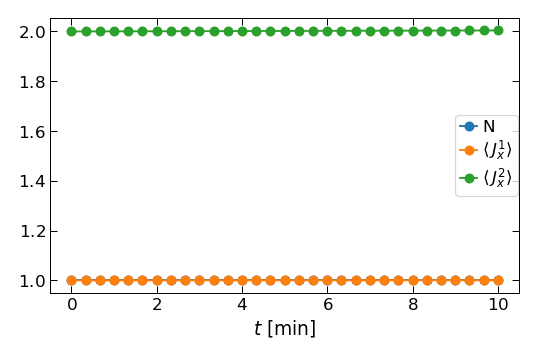

1.0007274066101597


<IPython.core.display.Javascript object>


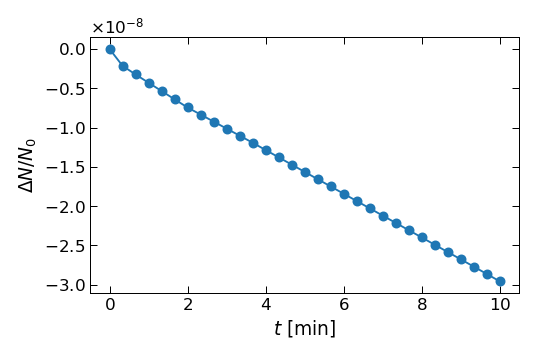

In [44]:
#############
## Moments ##
fig1,ax1 = calc.plot_moments(plane=0)
print(calc.moments_x[-1,1]/calc.moments_x[0,1])
fig2,ax2 = calc.plot_intensity(fmt='-o')

## 3.1 - Distribution Evolution

<IPython.core.display.Javascript object>


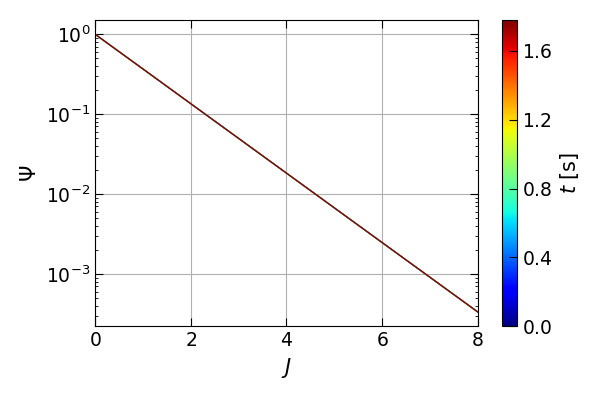

<IPython.core.display.Javascript object>


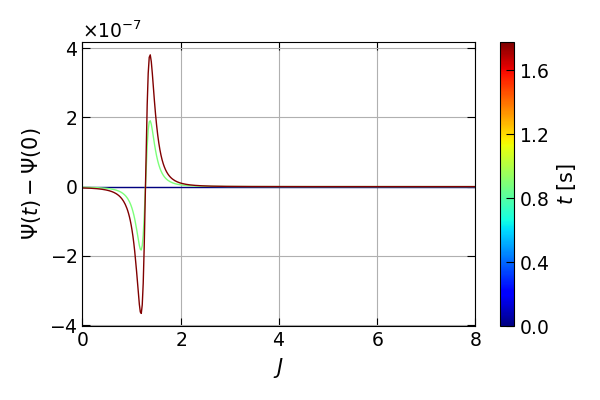

<IPython.core.display.Javascript object>


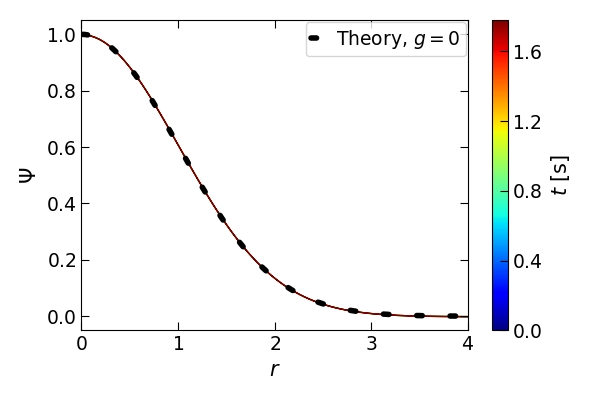

<IPython.core.display.Javascript object>


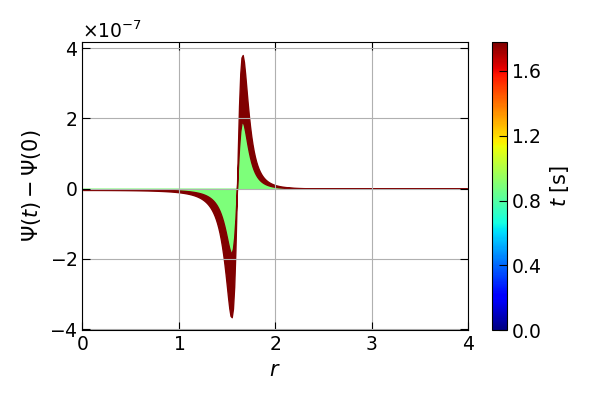

<IPython.core.display.Javascript object>


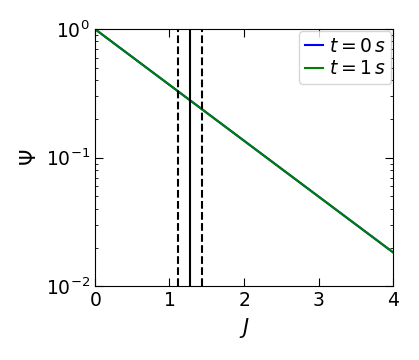

<IPython.core.display.Javascript object>


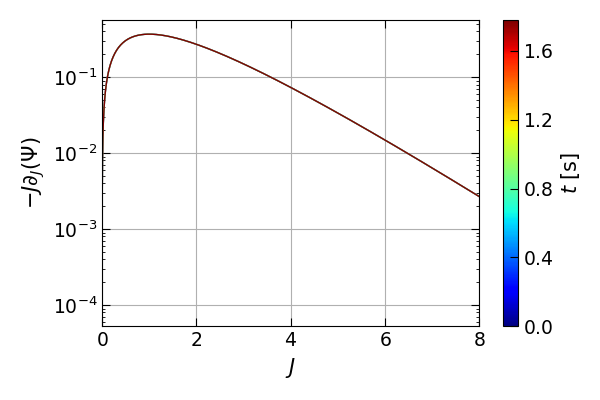

<IPython.core.display.Javascript object>


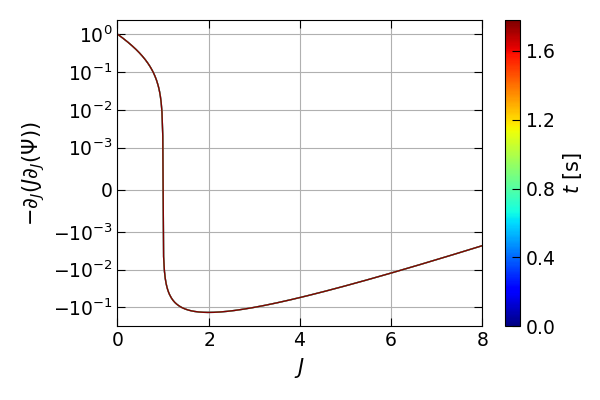

In [39]:
#############################
######## 1D plotting ########
if calc.ND==1:
    ## Distributions
    if 1:
        out1=calc.plot_psis_1Dx(0,['linear','log'][1],flag_extDist=0,bool_theory_g0=0,flag_fill=0,)
        out2=calc.plot_psis_1Dx(1,flag_extDist=0)
        out2[1].grid(False)
    #     out3=calc.plot_psis_1Dx(2,plot_rmax=calc.xMax_ProjX)
    else:
        out1=calc.plot_psis_1Dy(0,['linear','log'][1],fignradd=100)
        out2=calc.plot_psis_1Dy(1,fignradd=100)
        out3=calc.plot_psis_1Dy(2,plot_rmax=calc.xMax_ProjX,fignradd=100)
    fig1,ax1,fig2,ax2 = out1
    
    fig1,ax1 = plt.subplots(1)
    ax1.set_ylabel(r'$\Psi$')
    ax1.set_xlabel(r'$J$')
    for i,it in enumerate([0,1,]):
        ax1.plot(calc.G.Jxc,calc.psis[it],c=['b','g','r'][i],label=r'$t=%.0f\,%s$'%(calc.tsPSI[it]/calc.time_scale,calc.tunit))
    ax1.set_yscale('log')
    ax1.legend(loc=0)
    
    if calc.iCoeff>2:
        cW = np.sqrt(np.real(calc.M.wmodeLdDQx[0]**2))
        ax1.axvline(cW/calc.M.Q.ax,c='k')
        for i in [-1,1]:
            ax1.axvline((cW+i*calc.M.wmodeLdDQx[0].imag)/calc.M.Q.ax,c='k',ls='--')
        ax1.set_xlim(0,4)
        ax1.set_ylim(1e-2,1)
        ax1.grid(False)
    #     fig1.set_size_inches(figwidth, figheight*1.2)
        fig1.set_size_inches(figwidth*.7, figheight*.9)
        fig1.tight_layout()
        fig1.savefig(pltstorage+'DPsi1D_NEW_%s.eps'%filename)

    ## Derivative of distributoin
    calc.plot_dPsis_1Dx(order=1,flag_JdPsidJ=flag_JdPsidJ)
    outx = calc.plot_dPsis_1Dx(order=2,flag_JdPsidJ=flag_JdPsidJ)

    plt.yscale('symlog', linthreshy=1e-3)
    outx[0].tight_layout()

    ###############################
    ####### Saving 1D plots #######
    if flag_savefig:
        out2[0].savefig(pltstorage+'Psi1D_%s.eps'%filename)
    #     '03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e.eps'%(ax,bx,gx,sigma_kx**2*nturns))

<IPython.core.display.Javascript object>


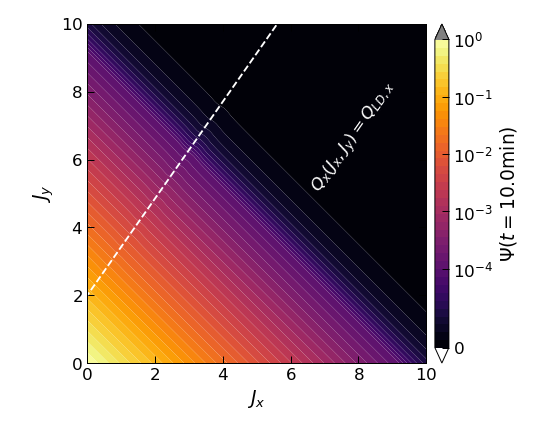

Qcoh (-6.978747341105138e-05-9.535843538933338e-06j)
-6.978762010911854e-05 5e-05


<IPython.core.display.Javascript object>


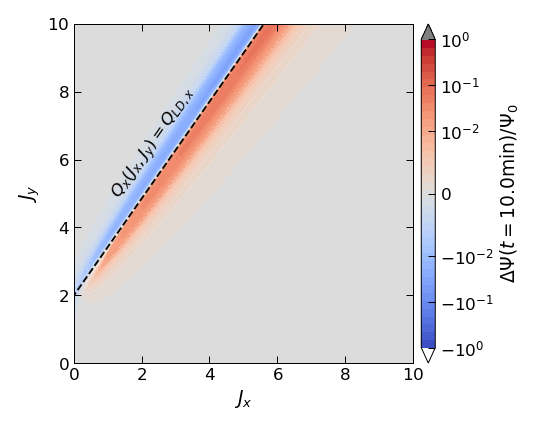

Qcoh (-6.978747341105138e-05-9.535843538933338e-06j)
-6.978762010911854e-05 5e-05


In [31]:
#############################
######## 2D plotting ########
"""
plot_2D(X,Y,Z,iStyle = 1,xMax=15,yMax=15,vlmin=-1,vlmax=1,nDec=1,
            xlabel=r'$J_x$',ylabel=r'$J_y$',clabel='LABEL',flag_cbar=1,**kwargs): 
    kwargs include:
        nlevels: number of levels used by contourf
        ax:      axis to plot along
def plot_Dist2D(self,flag_change=0,iTime=0,iStyle=1,interp=1,**kwargs):
    prefer (iStyle,interp)=(1,1),(0,0),(1,0)
    kwargs: 
        Local:       xMax,yMax,vlmin,vlmax,nDec
        Transferred: nlevels,ax
def plot_Coeff2D(self,iCoeffType=0,plane=0,nlevels=100,**kwargs):
    kwargs: 
        Local:       xMax,yMax,vlmin,vlmax,nDec
        Transferred: nlevels,ax
"""
mpl.rcParams.update({'image.cmap':'jet'})

def addLines(calc,ax,c='k',xy=(1.5,4.4)):
    y = np.array([0,JMax]); 
    if calc.iCoeff==2:
        x = (calc.M.Q.dQx(1,1)   -calc.M.Q.dQxdJy(1,1)*y)/calc.M.Q.dQxdJx(1,1)
        ax.annotate(r'$\Delta Q_x=0$',xy=xy,rotation = 55 ,ha='center',va='center',color=c)
        ax.plot(x,y,'--',c=c)
        if calc.M.N.sigma_ky>0:
            x=y
            y= (calc.M.Q.dQy(1,1)   -calc.M.Q.dQydJx(1,1)*x)/calc.M.Q.dQydJy(1,1)
            ax.annotate(r'$\Delta Q_y=0$',xy=(xy[1],xy[0]),rotation = 35,ha='center',va='center',color=c )
            ax.plot(x,y,'-',c=c)
    elif iCoeff>=3:
        for iQ,Qcoh in enumerate(calc.M.wmodeLdDQx):#[calc.M.wmodeLdDQx[0],calc.M.wmode__DQx[0]]):
            print('Qcoh',Qcoh)
            if iQ==2: continue
            Q0 = calc.M.Q.Q0x
            Qcoh = np.sqrt(np.real((Q0+Qcoh)**2))-Q0
            x = (Qcoh-calc.M.Q.dQxdJy(1,1)*y)/calc.M.Q.dQxdJx(1,1)
            print(Qcoh, calc.M.Q.dQxdJx(1,1))
            ax.plot(x,y,'--',c=c)
            if iQ==0:
                ax.annotate(r'$Q_x(J_x,J_y)=Q_{%s,x}$'%['LD','coh'][iQ],xy=xy,rotation = 55 ,color=c)



if calc.ND==2:
    temp = mpl.rcParams.get('image.cmap')
    JMax = 10
    iTime=calc.ntPSI-1
#     iTime=calc.nt-1
#     iTime=calc.nt//2
#     iTime =3
    interp =1
    
    ## Plot the distribution
    mpl.rcParams.update({'image.cmap':'inferno'})
    out=calc.plot_Dist2D(flag_change=0,iTime=iTime,iStyle=1,interp=1,nlevels=40,xMax=JMax,yMax=JMax) 
#     addLines(calc,out[1],c='white',xy= (JMax*.65,JMax*.8)) 
    addLines(calc,out[1],c='white',xy= (JMax*.65,JMax*.8)) 
    
    if flag_savefig and 1:
        plt.savefig(pltstorage+'Psi2D_'+filename+'_t=%.1fh.eps'%(tsPSI[iTime]/3600))

    ## Plot Change of the distribution
    mpl.rcParams.update({'image.cmap':'coolwarm'}) #RdBu_r coolwarm spectral_r twilight_shifted
    vmax=.6; nDec=0
    vmax=.01; nDec=2
#     vmax=.001; nDec=3
#     vmax=1; nDec=3
#     vmax=.5; nDec=0
    fig,ax,cb=calc.plot_Dist2D(flag_change=1,iTime=iTime,iStyle=1,interp=1,nlevels=40,xMax=JMax,yMax=JMax,
                        vlmax=vmax,vlmin=-vmax,nDec=nDec
                              ) 
    addLines(calc,ax,xy=(JMax*.1,JMax*.78))     
    
#     addLines(calc,ax,xy= (JMax*.65,JMax*.8)) 
    if flag_savefig:
        plt.savefig(pltstorage+'DPsi2D_'+filename+'_t=%.1f%s.eps'%(tsPSI[iTime]/time_scale,tunit))


    mpl.rcParams.update({'image.cmap':temp})
    ## Plot Diffusion coefficients
#     out=calc.plot_Coeff2D(iCoeffType=0,plane=0,vlmax=1e-5,nDec=2)


    
    
#     #############################
#     ## If make many plots in 1 ##
#     fac = 1.5
#     gridspec={'right':1-0.25/fac,'top':1-.05/fac,'bottom':0.2/fac,'wspace':0.1/fac, 'hspace':0.1/fac}#,'left':0.05}
#     fig,axs=plt.subplots(2,2,figsize=(figwidth*fac,figheight*fac*1.1),gridspec_kw=gridspec,sharex=True,sharey=True,
#                         squeeze=True,subplot_kw={'aspect':'equal'})
#     axs = axs.flatten()
#     for i in range(4):
#         iTime = (1+i)*1 -1
#         fig,ax,cb=calc.plot_Dist2D(flag_change=1,iTime=iTime,  iStyle=1,interp=0,flag_cbar=0,ax=axs[i],nDec=3,vlmax=1e-2,
#                                    xMax=JMax,yMax=JMax)  
#         ax.annotate('t=%.1f%s'%(tsODE[iTime]/time_scale,tunit),xy=(1,0))
#         if calc.M.Q.dQxdJx(1,1)!=0:
#             y = np.array([0,JMax])
#             if iCoeff==2:
#                 x = (calc.M.Q.dQx(1,1)   -calc.M.Q.dQxdJy(1,1)*y)/calc.M.Q.dQxdJx(1,1)
#                 ax.annotate(r'$\Delta Q_x=0$',xy=(3,4.4),rotation = 55 )
#             elif iCoeff>=3:
#                 x = (calc.M.wmodeLdDQx[0]-calc.M.Q.dQxdJy(1,1)*y)/calc.M.Q.dQxdJx(1,1)
#                 ax.annotate(r'$Q_x(J_x,J_y)=Q_{LD,x}$',xy=(0.5,8),rotation = 55 )
#             ax.plot(x,y,'k--')
            
#     for i in [1,3]: axs[i].set_ylabel(None)
#     for i in [0,1]: axs[i].set_xlabel(None)
#     caxis = fig.add_axes([gridspec['right']+0.02,gridspec['bottom'],0.02,gridspec['top']-gridspec['bottom']])
#     fig.colorbar(mappable=cb[0],cax = caxis,ticks=cb[1],extend='both',label=r'$\Delta\Psi(t)/\Psi_0$')#cb[2])
#     plt.tight_layout()


In [45]:
# X-distribution
if 0:
    from scipy.optimize import curve_fit
    def fitfunc(x,a,b,c):
        return a/(b*np.sqrt(2*np.pi))*np.exp(-0.5*(x/b)**2) +c
    
    Nx=101
    calc.psisPosX = np.zeros((calc.ntPSI,Nx)) ;
    x=calc.cart_x = np.linspace(-6,6,Nx)
    plt.figure()
    for i in [0,12]:
        calc.psis1Dx[i] = calc.J2D_proj_J1D(calc.G.Jxbx,calc.G.Jyby,calc.psis2D[i],0)
        calc.psisPosX[i]     = calc.J1D_proj_x1D(calc.cart_x,calc.G.Jxc,calc.psis1Dx[i])

        y = calc.psisPosX[i]
        plt.plot(x ,y,label=r'$t=%.0f$h'%(calc.tsPSI[i]/3600),ls=['-','-.'][i==0])
        if i>0:
            # Fit
            ind = y>np.max(y)*0.0
            pout,pcov = curve_fit(fitfunc,x[ind],y[ind])
            plt.plot(x ,fitfunc(x,pout[0],pout[1],pout[2]),'--',label='Gaussian fit ($%.0f$h)'%(calc.tsPSI[i]/3600))
            print('Largest error',np.max(fitfunc(x,pout[0],pout[1],pout[2])-calc.psisPosX[i])/np.max(calc.psisPosX[i]))
            print(pout)
#     plt.plot(x ,.91/np.sqrt(np.pi*2)*np.exp(-x**2/2))
    
    plt.xlabel(r'$x$  $[\sigma_{x0}]$')
    plt.xlim(-3,3)
    plt.ylabel(r'$\Psi$')
    plt.legend(loc=0)
    plt.tight_layout()

## 3.2 Stability Evolution

In [14]:

# calc.calc_InterpDist(calc.psis[-1],plane=0)
# distribution = calc.interpDistx
# detuning = calc.M.Q 
# integrator = TrapzIntegrator(distribution, detuning, maxJ=18,n_steps=1000)

# freeQs = get_tune_range_focused(detuning,margin=2e-5, n_samples=100,center_tune=0.31+calc.M.wmodeLdDQx[0].real,width_ratio=0.05)
# cohDQs = np.zeros((len(freeQs)), dtype='complex')
# for k, q in enumerate(freeQs):
#     cohDQs[k] = 2*integrator.integrate(q,epsilon=calc.integrator_epsilon) \
#                 - integrator.integrate(q,epsilon=calc.integrator_epsilon*2)# - 1j*calc.integrator_epsilon

[-6.699e-06 -5.951e-06 -5.486e-06 -5.039e-06 -4.580e-06 -4.114e-06
 -3.656e-06 -3.351e-06 -3.054e-06 -2.746e-06 -2.430e-06 -2.149e-06
 -1.992e-06 -1.831e-06 -1.671e-06 -1.502e-06 -1.339e-06 -1.177e-06
 -1.014e-06 -8.515e-07 -6.886e-07 -5.315e-07 -3.701e-07 -2.085e-07
 -4.122e-08  1.227e-07  2.859e-07  4.493e-07  6.129e-07  7.584e-07
  8.952e-07]


<IPython.core.display.Javascript object>


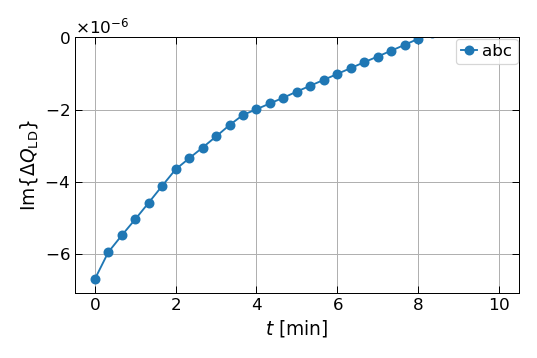

Latency (x) = 8.08 min


<IPython.core.display.Javascript object>


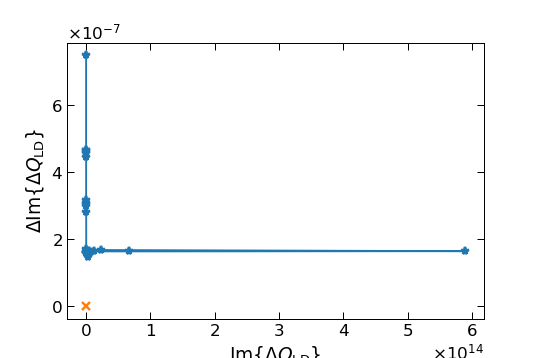

In [38]:
# calc.flagFindalpha = [0,0]
# calc.SD_calcGrowthRate(plane=0,modeDQ = calc.M.wmode__DQx[0],debug=0,flagFindalpha=[0,0])
if flag_dpsidt==1 or 1:
    print(calc.growthRatex)
    out=calc.SD_plotGrowthRate(plane=0,flag_normalize=0,fmt='x',label='abc')
    plt.figure()
    GR1 = calc.growthRatex
    plt.plot(1/GR1[:-2]**2,np.diff(GR1[:-1]),'-*')
    plt.plot(0,0,'x')
    plt.xlabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$')
    plt.ylabel(r'$\Delta\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$')

In [13]:
flag_stabilityMargin = 1
flag_effectiveStrength=0

if np.size(scales)>0:
    ratio=np.nan
    calc.SD_calcEffectiveStrength(plane=0,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=ratio)
    calc.SD_calcEffectiveStrength(plane=1,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=ratio)

if flag_stabilityMargin and 0:
    calc.SD_calcStabilityMargin(plane=0, mode=calc.M.wmode__DQx[0])
    margin1 = calc.stabilityMarginx
    calc.SD_calcDampingRate(plane=0, mode=calc.M.wmode__DQx[0])
    margin2 = calc.stabilityMarginx
    

[  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500. 520. 540.
 560. 580. 600.]


<IPython.core.display.Javascript object>


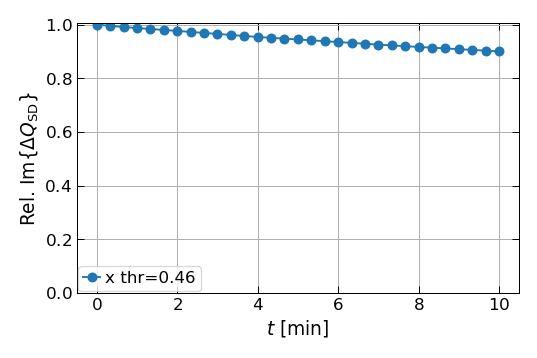

ERROR in SD_plotStabilityMarginy: Could not find attributes


<IPython.core.display.Javascript object>


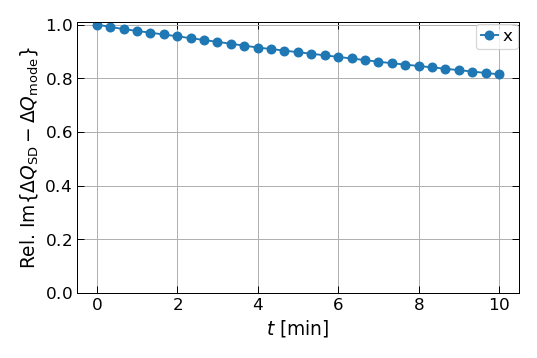

<IPython.core.display.Javascript object>


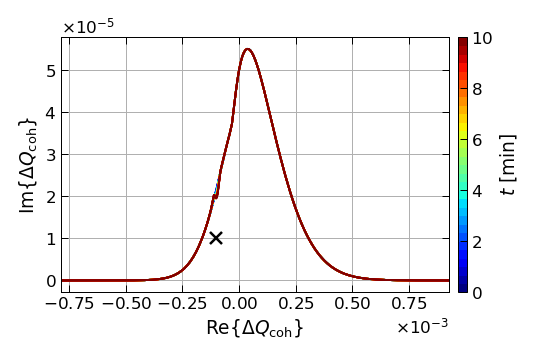

<IPython.core.display.Javascript object>


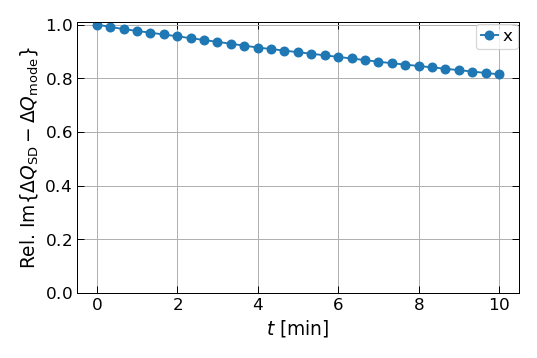

<IPython.core.display.Javascript object>


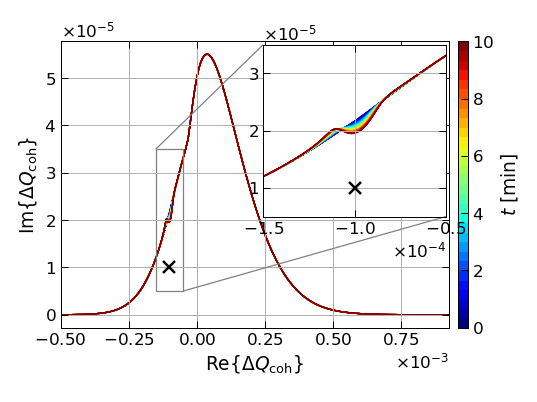

ERROR in SD_plotStabilityMarginy: Could not find attributes


In [32]:
#############################################
## Stability Margin and Effective Strength ##
if not 'scale' in locals():
    scale=1
    
print(calc.tsSD)
# print(calc.cohDQsAllx)

if flag_stabilityMargin:
    out=calc.SD_plotStabilityMargin(plane=0,flag_relative=0,flag_normalize=1,label='x',flag_plotInscribed=0)
    out=calc.SD_plotStabilityMargin(plane=1,flag_relative=0,flag_normalize=1,label='y',flag_plotInscribed=0,ax=out[1])

    tmax = calc.tmax
    tmax =240
#     tmax=10
    out=calc.SD_plotStabilityMargin(plane=0,flag_relative=1,flag_normalize=1,label='x',
                                    flag_plotInscribed=1,flag_fillSD=0,tmax=tmax)
    if 1:
        flag_fillSDloc=1
        out=calc.SD_plotStabilityMargin(plane=0,flag_relative=1,flag_normalize=1,label='x',flag_plotInscribed=1,
                                       flag_fillSD=flag_fillSDloc,tmax=tmax)
        
        if calc.iCoeff>=3:
            # Inscribed axis
#             x1, x2, y1, y2 = -1.7e-4, -.5e-4, 1e-5, 7e-5 # specify the limits
            x1, x2, y1, y2 = -1.5e-4, -.5e-4, .5e-5, 3.5e-5 # specify the limits , MCBI 1.5
#             x1, x2, y1, y2 = -4.00e-4, -1.5e-4, 0e-5, 20e-5 # specify the limits
#             x1, x2, y1, y2 = -3.5e-4, -1e-4, 0e-5, 20e-5 # specify the limits
            width="47%"
            if 0:
                x1, x2, y1, y2 = -1.25e-4, -.75e-4, .5e-5, 3.5e-5 # specify the limits
                width="23%"
            nameadd=''
            if 1:
                ax1=out[3]
                
#                 if 1:
#                     plt.figure()
#                     ax1=plt.gca()
                
                
                axins = inset_axes(ax1, width=width,height="60%",borderpad=0.2) # zoom-factor: 2.5, location: upper-left
                axins.plot(calc.M.wmode__DQx[0].real,calc.M.wmode__DQx[0].imag,'kx',ms=10,mew=2)
#                 calc.SD_plotSD(plane=0,flag_fillSD=1,ax=axins,tmax=tmax)
                calc.SD_plotSD(plane=0,flag_fillSD=flag_fillSDloc,ax=axins,tmax=tmax)
                axins.set_xlim(x1, x2) # apply the x-limits
                axins.set_ylim(y1, y2) # apply the y-limits
                axins.xaxis.set_visible('False')
                axins.yaxis.set_visible('False')
                axins.set_xlabel('')
                axins.set_ylabel('')

                mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
                axins.grid(True)
                out[3].set_xlim(left=-5e-4*1)
                nameadd='zoom_'
                out[2].set_size_inches(figwidth, figheight*9/8)
            else:
                out[3].set_ylim(y1,y2)
                out[3].set_xlim(x1,x2)
                out[2].set_size_inches(figwidth, figheight*0.8)


            i=0
            pltname = 'SD%s_%s%s_%s'%(['x','y'][i],['line','fill'][flag_fillSDloc],['_scale%.2f'%scale,''][0],nameadd)+filename
            pltname = 'SDx_'+filename
            out[2].savefig(pltstorage+pltname+'.eps',format='eps')


        out=calc.SD_plotStabilityMargin(plane=1,flag_relative=1,flag_normalize=1,label='y',flag_plotInscribed=1,
    #                                     ax=out[1]
                                        
                                   )

if flag_effectiveStrength:
    if calc.M.N.sigma_ky>0:
        ylabel = r'Both planes, $\sigma_{ky}=\sigma_{kx}$'
        out=calc.SD_plotEffectiveStrength(plane=1,label=ylabel,fmt_string='-%s'%markers[2],flag_plotInscribed=0,ax=out[1],iTime_step=1)
    else:
        xlabel = ['x' , r'Horizontal, $\sigma_{ky}=0$'][1]
        ylabel = ['y' , r'Vertical, $\sigma_{ky}=0$'][1]
        out=calc.SD_plotEffectiveStrength(plane=0,label=xlabel,fmt_string='-%s'%markers[0],flag_plotInscribed=1,iTime_step=2,flag_fillSD=False)#ax=out[1]
        out=calc.SD_plotEffectiveStrength(plane=1,label=ylabel,fmt_string='-%s'%markers[1],flag_plotInscribed=1,ax=out[1],flag_fillSD=False,iTime_step=1)

# out[0].set_size_inches(figwidth,figheight*.7)
# out[1].set_ylabel('Rel. eff. detuning')
# out[1].axis([0,25,0,1.24])
# out[1].grid(False)



In [12]:
out[0].set_size_inches(figwidth,figheight*.8)
out[0].savefig(pltstorage+'EffdQ_%s.eps'%filename)

<IPython.core.display.Javascript object>


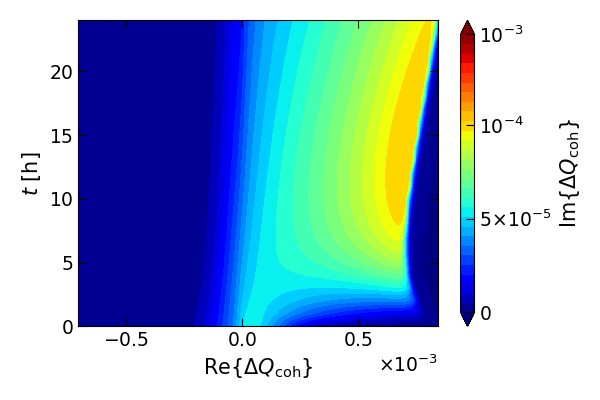

<IPython.core.display.Javascript object>


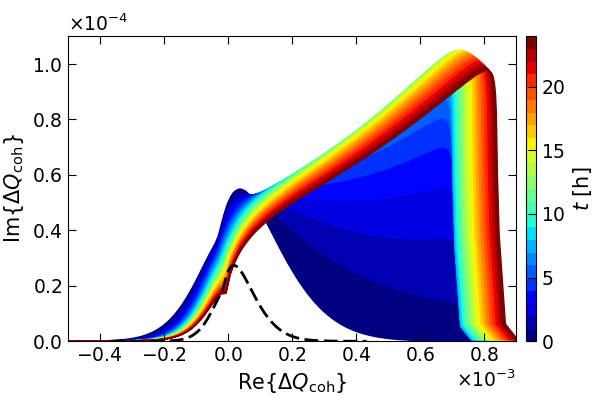

In [19]:
#################################
## Stability Diagram Evolution ##
flag_SD_constituents=0
flag_fillSD =1
savedir = '04_Plots_Diffusion/'
for i in [0]:
    
    basex = np.linspace(-1,1,100)*1.2e-3
    figj,axj = calc.SD_plotWaterfall(plane=i,flag_logScale=True)
     
#     figname = 'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d'%(['x','y'][i],calc.M.Q.ax,calc.M.Q.bx,calc.M.gx,calc.G.BC_xMax)
                #'_Ioct%.0f_en%.1fum'%(i_octupoles,emittance*1e6)
    
    figname = 'SD%s_%s_'%(['x','y'][i],['line','fill'][flag_fillSD])+filename
    figi,axi = calc.SD_plotSD(i,flag_fillSD ,flag_savefig, pltstorage, 
                              figname = figname, 
                              flag_SD_constituents=flag_SD_constituents)

    axi.set_xlim(-1e-3,1.1e-3)
    if i==0:
        axi.set_xlim(-5e-4,9e-4)
    else:
        axi.set_xlim(-8e-4,6e-4)
    axi.set_ylim(bottom=0)
    
    if 1:
#         axi = figi.gca()
        if i==0:
            axi.plot(calc.cohDQs_halfIx.real, calc.cohDQs_halfIx.imag, c='k',ls='--',lw=2,dashes=(5, 2)
                         ,label=r'$\Delta Q/2$')
        else:
            axi.plot(calc.cohDQs_halfIy.real, calc.cohDQs_halfIy.imag, c='k',ls='--',lw=2,dashes=(5, 2)
                         ,label=r'$\Delta Q/2$')
#                     ,label=r'$I_\mathrm{oct}=%.0f$ $\mathrm{A}$'%(200))
    #     axi.legend(loc=0)
#         axi.set_ylim(0,np.max(tune_shifts.imag)*4)
#         axi.set_xlim(-1e-3*[.5,1][i],1e-3)
        figi.tight_layout()
        axi.grid(False)
        if flag_savefig : 
#             fname = savedir+'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_digginglimit'%(['x','y'][i],
#                                a,b,g,BC_xMax) #'_Ioct%.0f_en%.1fum'%(i_octupoles,emittance*1e6)
            fname = pltstorage + figname
            figi.savefig(fname+'.eps',format='eps', dpi=figi.dpi)
#             figi.savefig(fname+'.pdf',format='pdf', dpi=figi.dpi)

#             fname = savedir+'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum_waterfall'%(['x','y'][i],
#                                a,b,g,BC_xMax,i_octupoles,emittance*1e6)
#             figj.savefig(fname+'.eps',format='eps', dpi=figi.dpi)

            


## 3.1a EOY simple stability diagram drilling

<IPython.core.display.Javascript object>


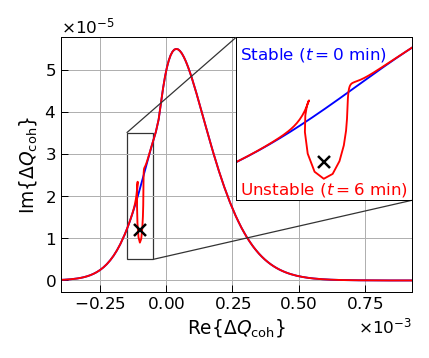

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [20]:
# EOY slide simple plot

cohDQsAll = calc.cohDQsAllx
x1, x2, y1, y2 = -1.5e-4, -.5e-4, .5e-5, 3.5e-5 # specify the limits
width="50%"

fig,ax=plt.subplots(1,figsize= (figwidth*.8,figheightpres*.8))
axins = inset_axes(ax, width=width,height="64%",borderpad=0.0) # zoom-factor: 2.5, location: upper-left
for axi in [ax,axins]:
    axi.plot(cohDQsAll[0].real,cohDQsAll[0].imag,'b',label=r'$t=0$ $\mathrm{min}$')
    axi.plot(cohDQsAll[-1].real,cohDQsAll[-1].imag,'r',label=r'$t=6$ $\mathrm{min}$')
    axi.plot(calc.M.wmode__DQx[0].real,calc.M.wmode__DQx[0].imag,'kx',ms=10,mew=2)

ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")
ax.set_ylabel("$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$")
ax.grid(True)

minx = np.min(cohDQsAll[0].real)
maxx = np.max(cohDQsAll[0].real)
ax.set_xlim(-4e-4,maxx)
# ax.legend(loc=(.65,0.07))

axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.xaxis.set_visible('False')
axins.yaxis.set_visible('False')
axins.axes.get_xaxis().set_visible(False)
axins.axes.get_yaxis().set_ticks([])
axins.set_xlabel('')
axins.set_ylabel('')
axins.annotate(r'Stable ($t=0$ $\mathrm{min})$',xy=(-1.48e-4,3.1e-5),color='b',ha='left')
axins.annotate(r'Unstable ($t=6$ $\mathrm{min})$',xy=(-1.e-4,.6e-5),color='r',ha='center')

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.2")
axins.grid(True)
fig.tight_layout()
fig.savefig(pltstorage + 'EOY_slide_simpleDrilling.eps')

## 3.1b Derivative of ML/MC

In [24]:
# if i_dpsidt==0 or 1:
#     calc.SD_calcGrowthRate(plane=0,mode = calc.M.wmode__DQx[0],debug=0,flagFindalpha=1)
#     print(calc.growthRatex)
#     out=calc.SD_plotGrowthRate(plane=0,flag_normalize=0,fmt='x',label='abc')
#     # out[1].set_xscale('log')
#     # out[1].set_xlim(0.1,50)
#     plt.figure()
#     GR = calc.growthRatex
#     plt.plot(1/GR[:-2]**3,np.diff(GR[:-1]),'*')
#     # plt.xlim(right=0); plt.ylim(bottom=0)
#     plt.plot(0,0,'x')

In [107]:
print(calc.indexSD)
print(calc.tsPSI[24])
print(calc.tsSD[22])
print(dampDQ.real,dQ0)

[0 3 6]


IndexError: index 24 is out of bounds for axis 0 with size 9

In [40]:
## Why we should not update Re(DQ) in taylor approach
idist = 17
distribution = calc.postProc_interpDistNri(idist,interp_order=1,plane=0)
detuning = calc.M.Q
integrator = TrapzIntegrator(distribution, detuning, maxJ=18,n_steps=1000)


freeDQ = np.linspace(dQ0-5e-5,dQ0+5e-5,50)
cohDQ = np.zeros((len(freeDQ)), dtype='complex')
for k, q in enumerate(freeDQ):
    cohDQ[k] = (2*integrator.integrate(calc.M.Q.Q0x+q,epsilon=integrator_epsilon) -
                integrator.integrate(calc.M.Q.Q0x+q,epsilon=integrator_epsilon*2))

dampDQ = calc_LandauDampedOneMode(calc,integrator,calc.M.Q.Q0x,calc.M.wmode__DQx[0],flagFindalpha=1)
dampDQ = calc_LandauDampedOneMode(calc,integrator,calc.M.Q.Q0x,calc.M.wmode__DQx[0],flagFindalpha=0)
dQ0      = dampDQ.real
freeGRs = integrator_epsilon*np.logspace(0,2,20)
cohDQLine= np.zeros((len(freeGRs)), dtype='complex')
for k, q in enumerate(freeGRs):
    cohDQLine[k] = integrator.integrate(calc.M.Q.Q0x+dQ0,epsilon=q) 
    
freeGRs2 = np.concatenate((-freeGRs,freeGRs))

 

# cohDQLine2= np.zeros((len(freeGRs2)), dtype='complex')
# for k, q in enumerate(freeGRs2):
#     cohDQLine2[k] = calc_LandauDampedOneMode(calc,integrator,calc.M.Q.Q0x,calc.M.wmode__DQx[0].real+q*1j,flagFindalpha=1,tol=5e-4)
# alpha=5.35e-01+1.87e-01*1j
# cohDQLine2 =cohDQLine[0] + 1j*freeGRs2*alpha

NameError: name 'dQ0' is not defined

In [38]:
# dampDQ = calc_LandauDampedOneMode(calc,integrator,calc.M.Q.Q0x,calc.M.wmode__DQx[0],flagFindalpha=1)
# Found alpha!=1, alpha=2.70e-01+-1.29e-01i
print(dampDQ)
print(dQ0)
print(1j*(np.diff(freeGRs)[0]/np.diff(cohDQLine)[0]))
print(freeGRs)
print(freeGRs2)

NameError: name 'dampDQ' is not defined

In [39]:
freeGRs2 = np.concatenate((-freeGRs,freeGRs))
# alpha=5.35e-01+1.87e-01*1j
# alpha=1
# alpha=2.70e-01+-1.29e-01j
alpha = alpha=9.99e-01+-2.06e-01j
cohDQLine2 =(cohDQLine[0] -np.diff(cohDQLine)[0]/(np.diff(freeGRs)[0])*freeGRs[0]) + 1j*freeGRs2/alpha

plt.figure()
# cohDQ = calc.cohDQsAllx[np.argmax(15==calc.indexSD)]
plt.plot(cohDQ.real,cohDQ.imag)
plt.plot(cohDQLine.real,cohDQLine.imag,'xr',ms=3)
plt.plot(np.ones_like(freeGRs)*dQ0,freeGRs,'r',lw=2)
plt.plot(calc.M.wmode__DQx[0].real,calc.M.wmode__DQx[0].imag,'kx',ms=10)
plt.plot(cohDQLine2.real,cohDQLine2.imag,'xg',ms=3)
plt.plot(np.ones_like(freeGRs2)*dQ0,freeGRs2,'g--')
plt.grid(True)

NameError: name 'freeGRs' is not defined

## 3.1c Integrand plot

0.31994
integrated (-0.0002152017658726701+0.0007307494470427365j) (-0.00013687933477268187+7.692034488325237e-05j)


<IPython.core.display.Javascript object>


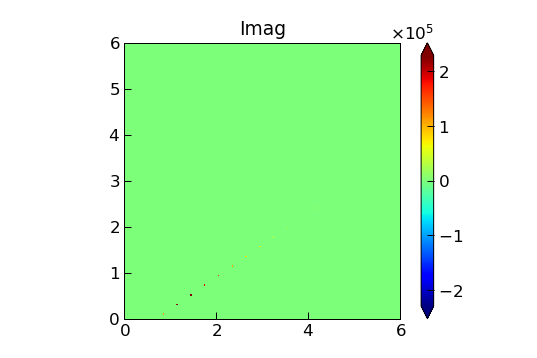

<IPython.core.display.Javascript object>


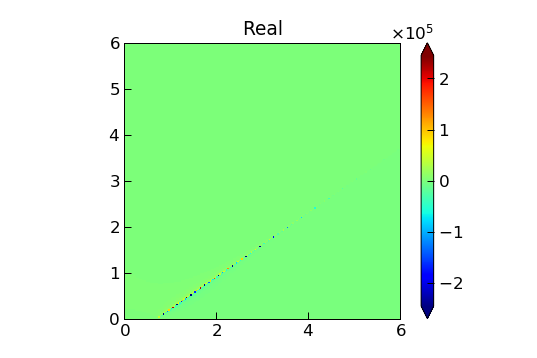

In [31]:
# Integrand plot
import matplotlib.cm as cm

plane=1

distribution = calc.postProc_interpDistNri(i=calc.ntPSI-1,plane=plane )
detuning = [calc.M.Q,calc.M.Qy][plane]
Q=[detuning.Q0x,detuning.Q0y][plane] +1.43e-4 * -1
Q=0.32  - 6e-5
jmax=6
print(Q)
dispersion = Dispersion(distribution,detuning,Q,integrator_epsilon/100)
x = np.linspace(0,jmax,200)
JX,JY = np.meshgrid(x,x)
if plane==0:
    integrand = dispersion.getValue(JX,JY)
else:
    integrand = dispersion.getValue(JY,JX)

integrator = TrapzIntegrator(distribution, detuning, maxJ=18)    
print('integrated',-1/np.trapz(np.trapz(integrand, x), x),integrator.integrate(Q,integrator_epsilon))



cmap  = cm.get_cmap(None)

for i in range(2):
    plt.figure()
    F = [integrand.imag,integrand.real][i]
    vmax = np.max(F)
    plt.imshow(np.flipud(F),extent=(0,jmax,0,jmax),cmap=cmap,vmin=-vmax,vmax=vmax)
    plt.colorbar(extend='both')
    plt.title(['Imag','Real'][i])
# plt.figure()
# plt.imshow(np.flipud(integrand.real),extent=(0,jmax,0,jmax),cmap=cmap,vmin=None)
# plt.colorbar(extend='both')
# plt.title('Real')



## 1.0 - Helper Functions (to be placed elsewhere)

In [29]:
import matplotlib.colors as colors
import scipy as sc
import scipy.stats as st
import scipy.sparse as sp
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import multiprocessing as mp

# PySSD
import seaborn as sns
import sys,time
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
from PySSD.Dispersion import Dispersion
from PySSD.Integrator import FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator

#PyRADISE
from LebedevHelper import *
def sci_not(num,dec,flag_ignore1=False):
    if num>0:
        exp = int(np.log10(num)+100)-100
        num = num/10**exp
        sci = r'$%.*f\!\times \!10^{%d}$'%(dec,num,exp)
        if flag_ignore1 and np.round(num)==1:
            sci = r'$10^{%d}$'%(exp)
    else:
        sci = '$0$'
    return sci

################
## PySSD help ##
def findQs(detuning, stepSize=5E-5, maxJ=18.0, dJ=0.1, margin=1):
    '''
    '''
    myMin = 1.0
    myMax = 0.0
    for jx in np.arange(0, maxJ, dJ):
        for jy in np.arange(0, maxJ, dJ):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.arange(myMin-margin*stepSize, myMax+margin*stepSize, stepSize)

def get_tune_range(detuning, maxJ=18.0, margin=1e-4, n_samples=100):
    myMin = 1.0
    myMax = 0.0
    for jx in np.linspace(0, maxJ, 100):
        for jy in np.linspace(0, maxJ, 100):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.linspace(myMin - margin, myMax + margin, n_samples)

class MyDistribution1D(Distribution):
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0,bool_radial=0,interp_order=1):
        self._Jb=Jb.tolist() 
        if bool_radial and 0:
            Jbsq = np.sqrt(Jb)
            self._Jc = Jbsq[1:]*Jbsq[:-1]
        else:
            self._Jc=Jc.tolist()
        self._Psic=Psic.tolist() #+[0]
        self._dPsi=dPsi.tolist() #+[0]
#         self.interp_psi     = sc.interpolate.interp1d(self._Jb,self._Psic,kind='previous')
#         self.interp_dpsidJx = sc.interpolate.interp1d(self._Jc,self._dPsi,kind='previous',bounds_error=False,fill_value="extrapolate")
        kind = ["nearest",'slinear','quadratic','cubic'][interp_order]
        self.interp_psi     = sc.interpolate.interp1d(self._Jc,self._Psic,kind=kind,bounds_error=False,fill_value="extrapolate")
        self.interp_dPsidJx = sc.interpolate.interp1d(self._Jb[1:-1],self._dPsi,kind=kind,bounds_error=False,fill_value="extrapolate")

    def getValue(self, jx, jy):
        return self.interp_psi(jx)*np.exp(-jy)

    def getDJx(self, jx, jy):
        return self.interp_dPsidJx(jx)*np.exp(-jy)

    def getDJy(self, jx, jy):
        return -self.getValue(jx, jy)
    

    
class MyDistribution1Dy(MyDistribution1D):
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0):
        MyDistribution1D.__init__(self,Jb,Jc,Psic,dPsi)
#     def getValue(self, jx, jy):
#         return super().getValue(jy,jx)
    def getDJx(self,jy,jx):
        return super().getDJy(jx,jy)
    def getDJy(self,jy,jx):
        return super().getDJx(jx,jy)
    
    
class MyDistribution2D(Distribution):
    #TODO
    def __init__(self,Jxbx=0,Jxc=0,Jyby=0,Jyc=0,Psic=0,dPsidJx=0,dPsidJy=0,bool_radial=0,interp_order=0):
        self._Jxbx= Jxbx.copy()
        self._Jyby= Jyby.copy()
        if bool_radial :
            Jxbxsq = np.sqrt(Jxbx)
            self._Jxc = Jxbxsq[1:]*Jxbxsq[:-1]
            Jybysq = np.sqrt(Jyby)
            self._Jyc = Jybysq[1:]*Jybysq[:-1]
        else:
            self._Jxc=Jxc.copy()
            self._Jyc=Jyc.copy()
                
        self._Psic=Psic.copy() 
        self._dPsidJx=dPsidJx.copy()
        self._dPsidJy=dPsidJy.copy()
        self._interp_order= interp_order
        if interp_order==0:
            temp_interp_psi = sc.interpolate.RegularGridInterpolator((self._Jxc,self._Jyc),self._Psic.T,
                                   method='nearest',bounds_error=False,fill_value=None)
            temp_interp_dPsidJx = sc.interpolate.RegularGridInterpolator((self._Jxbx[1:-1],self._Jyc),self._dPsidJx.T,
                                   method='nearest',bounds_error=False,fill_value=None)
            temp_interp_dPsidJy = sc.interpolate.RegularGridInterpolator((self._Jxc,self._Jyby[1:-1]),self._dPsidJy.T,
                                   method='nearest',bounds_error=False,fill_value=None)
            self.interp_psi     = temp_interp_psi
            self.interp_dPsidJx = temp_interp_dPsidJx
            self.interp_dPsidJy = temp_interp_dPsidJy
#             self.interp_psi     = lambda a,b: temp_interp_psi((a,b))
#             self.interp_dPsidJx = lambda a,b: temp_interp_dPsidJx((a,b))
#             self.interp_dPsidJy = lambda a,b: temp_interp_dPsidJy((a,b))
        else :
            J0 = [None,0][bool_radial]
            J0 = None
            temp_interp_psi     = sc.interpolate.RectBivariateSpline(self._Jyc,self._Jxc,self._Psic,
                                                                 kx=interp_order,ky=interp_order,bbox=[0,Jyby[-1],0,Jxbx[-1]])
            temp_interp_dPsidJx = sc.interpolate.RectBivariateSpline(self._Jyc,self._Jxbx[1:-1],self._dPsidJx,
                                                                 kx=interp_order,ky=interp_order,bbox=[J0,Jyby[-1],J0,Jxbx[-1]])
            temp_interp_dPsidJy = sc.interpolate.RectBivariateSpline(self._Jyby[1:-1],self._Jxc,self._dPsidJy,
                                                                 kx=interp_order,ky=interp_order,bbox=[J0,Jyby[-1],J0,Jxbx[-1]])
            #Notice shift of input a,b -> b,a
            self.interp_psi     = temp_interp_psi
            self.interp_dPsidJx = temp_interp_dPsidJx
            self.interp_dPsidJy = temp_interp_dPsidJy
#             self.interp_psi = lambda a,b:     temp_interp_psi(b,a,grid=False)
#             self.interp_dPsidJx = lambda a,b: temp_interp_dPsidJx(b,a,grid=False)
#             self.interp_dPsidJy = lambda a,b: temp_interp_dPsidJy(b,a,grid=False)
                


    def getValue(self, jx, jy=0):
        if self._interp_order==0:
            return self.interp_psi((jx,jy))
        else:
            return self.interp_psi(jy,jx,grid=False)

    def getDJx(self, jx, jy=0):
        if self._interp_order==0:
            return self.interp_dPsidJx((jx,jy))
        else:
            return self.interp_dPsidJx(jy,jx,grid=False)
#         return self.interp_dPsidJx(jx,jy)

    def getDJy(self, jx, jy=0):
        if self._interp_order==0:
            return self.interp_dPsidJx((jx,jy))
        else:
            return self.interp_dPsidJx(jy,jx,grid=False)
#         return self.interp_dPsidJy(jx,jy)

class MyDistribution2Dy(MyDistribution2D):
    def __init__(self,Jxbx=0,Jxc=0,Jyby=0,Jyc=0,Psic=0,dPsidJx=0,dPsidJy=0,bool_radial=0,interp_order=0):
        MyDistribution2D.__init__(self,Jyby,Jyc,Jxbx,Jxc,Psic.T,dPsidJy.T,dPsidJx.T,bool_radial,interp_order)
        return

#########################
### Physics functions ###
#########################

## Diffusion coefficient
def DiffCoeff1(X,D_ibs,D_k):
    # X is the main coordinate (r, J)
    return X*(D_ibs + D_k)
def DiffCoeff2(X,D_ibs,D_k,dQ,dQAvg,g):
    # X is the main coordinate (r, J)
    g2 = g/2
    dmu = 2*np.pi*(dQ-dQAvg)
    return X*(D_ibs + D_k * LL(g2,dmu))
def DiffCoeffJxJy(Mach,Xp,JX,JY,plane,iCoeff):
    if iCoeff ==1:
        DD = DiffCoeff1(Xp,Mach.N.D_ibsx,Mach.N.D_kx)
    elif iCoeff==2:
        if plane==0:
            DD = DiffCoeff2(Xp, Mach.N.D_ibsx, Mach.N.D_kx,
                            Mach.Q.dQx(JX,JY), Mach.N.dQxAvg, Mach.gx)
        elif plane==1:
            DD = DiffCoeff2(Xp, Mach.N.D_ibsy, Mach.N.D_ky,
                            Mach.Q.dQy(JX,JY), Mach.N.dQyAvg, Mach.gy)
    else: 
        print('ERROR (DiffCoeff): iCoeff in [1,2] only')
    return DD
def DiffCoeffGrid(Mach,Grid,iCoeff):
    # Noise: Mach.N
    # Detuning: Mach.Q
    DDx = DiffCoeffJxJy(Mach,Grid.X,Grid.Jxbx2D,Grid.Jybx2D,plane=0,iCoeff=iCoeff)
    DDy = DiffCoeffJxJy(Mach,Grid.Y,Grid.Jxby2D,Grid.Jyby2D,plane=1,iCoeff=iCoeff)
    return DDx, DDy
   

## Drift coefficient
def DriftCoeff2(Jb,D_k,alpha,dQ,dQAvg,dQdJ,g):
    g2 = g/2
    dmu = 2*np.pi*(dQ-dQAvg)        
    return -Jb*((1-alpha)*D_k * dLLdm(g2,dmu) * pi2*dQdJ)
def DriftCoeffJxJy(Mach,JP,JX,JY,plane,iCoeff):
    if iCoeff==1:
        U = np.zeros_like(JX)
    elif iCoeff==2:
        if plane==0:
            U = DriftCoeff2(JP,Mach.N.D_kx,Mach.N.alpha,
                            Mach.Q.dQx(JX,JY),Mach.N.dQxAvg,Mach.Q.dQxdJx(JX,JY),Mach.gx)
        elif plane==1:
            U = DriftCoeff2(JP,Mach.N.D_ky,Mach.N.alpha,
                            Mach.Q.dQy(JX,JY),Mach.N.dQxAvg,Mach.Q.dQydJy(JX,JY),Mach.gy)
    else: 
        print('ERROR (DriftCoeff): iCoeff in [1,2] only')
    return U
def DriftCoeffGrid(Mach,Grid,iCoeff):
    # Noise: Mach.N
    # Detuning: Mach.Q  
    Ux = DriftCoeffJxJy(Mach,Grid.Jxbx2D,Grid.Jxbx2D,Grid.Jybx2D,plane=0,iCoeff=iCoeff)
    Uy = DriftCoeffJxJy(Mach,Grid.Jyby2D,Grid.Jxby2D,Grid.Jyby2D,plane=1,iCoeff=iCoeff)
    return Ux,Uy




##############################################################################################
##################### 
## Machine ##


class DetuningClass(object):
#     @abstractmethod
    def __init__(self,*args):
        pass
    def dQx(self,Jx,Jy):
        pass
    def dQy(self,Jx,Jy):
        pass
    def dQxdJx(self,Jx,Jy):
        pass
    def dQxdJy(self,Jx,Jy):
        pass
    def dQydJx(self,Jx,Jy):
        pass
    def dQydJy(self,Jx,Jy):
        pass
class LinearDetuningClass(DetuningClass):
    def __init__(self,Q0x,Q0y,ax,bx,ay,by,call_plane=0):
        self.Q0x = Q0x
        self.Q0y = Q0y
        self.ax0 = ax
        self.bx0 = bx
        self.ay0 = ay
        self.by0 = by
        self.ax = ax
        self.bx = bx
        self.ay = ay
        self.by = by
        self.call_plane = call_plane
    def scale(self,scale):
        self.ax = self.ax0*scale
        self.bx = self.bx0*scale
        self.ay = self.ay0*scale
        self.by = self.by0*scale
    def dQx(self,Jx,Jy):
        return self.ax*Jx + self.bx*Jy
    def dQy(self,Jx,Jy):
        return self.by*Jx + self.ay*Jy
    def dQxdJx(self,Jx,Jy):
        return self.ax
    def dQxdJy(self,Jx,Jy):
        return self.bx
    def dQydJx(self,Jx,Jy):
        return self.by
    def dQydJy(self,Jx,Jy):
        return self.ay
    def __call__(self,Jx,Jy):
        if self.call_plane==0:
            return self.Q0x + self.dQx(Jx,Jy)
        else:
            return self.Q0y + self.dQy(Jy,Jx) # opposite order because of PySSD
    def callVertical(self):
        return LinearDetuningClassY(self)
    def callScaledStrength(self,scale):
        return LinearDetuningClassScale(self,scale)

# class LinearDetuningClassScale(LinearDetuningClass):
#     def __init__(self,detuning,scale):
#         super().__init__(detuning.Q0x,detuning.Q0y,
#                             detuning.ax*scale,detuning.bx*scale,detuning.ay*scale,detuning.by*scale,
#                             call_plane=detuning.call_plane)
    
class NoiseClass(object):
    def __init__(self,f_rev, sigma_kx,dQxAvg,sigma_ky,dQyAvg,alpha,
                             sigma_ibsx,sigma_ibsy,
                             A_hx,dQ_hx,A_hy,dQ_hy):
        # White noise (Lebedev)
        self.sigma_kx = sigma_kx
        self.sigma_ky = sigma_ky
        self.dQxAvg = dQxAvg
        self.dQyAvg = dQyAvg
        self.alpha  = alpha
        self.D_kx = f_rev*self.sigma_kx**2/2
        self.D_ky = f_rev*self.sigma_ky**2/2
        # IBS, incoherent noise
        self.sigma_ibsx = sigma_ibsx
        self.sigma_ibsy = sigma_ibsy
        self.D_ibsx = f_rev*sigma_ibsx**2/2
        self.D_ibsy = f_rev*sigma_ibsy**2/2
        # Harmonic excitation
        self.A_hx  = A_hx
        self.dQ_hx = dQ_hx
        self.A_hy  = A_hy
        self.dQ_hy = dQ_hy
    
        
class MachineClass(object):
    def __init__(self,detuning,noise,g=0,f_rev = 11245):
        self.Q = detuning
        self.Qy= copy.deepcopy(detuning)
        self.Q.call_plane=0 ; self.Qy.call_plane=1
        self.N = noise
        
        self.gx = g
        self.gy = g
        self.f_rev = f_rev
        
class GridClass(object):
    def __init__(self, Ncx,JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,
                       Ncy,JyMax,JyAvg,BC_yMax,BC_yVal):
        self.Ncx = Ncx  ;  self.Nbx = Ncx+1
        self.Ncy = Ncy  ;  self.Nby = Ncy+1
        self.NcTot= self.Ncx * self.Ncy
        
        self.ncol = Ncx
        self.nrow = Ncy
        if self.Ncy ==1:
            JyMax=1
        
        self.JxAvg = JxAvg  ;  self.rxAvg = np.sqrt(2*JxAvg)
        self.JxMax = JxMax  ;  self.rxMax = np.sqrt(2*JxMax)
        self.JyAvg = JyAvg  ;  self.ryAvg = np.sqrt(2*JyAvg)
        self.JyMax = JyMax  ;  self.ryMax = np.sqrt(2*JyMax)
        
        self.bool_radial = (bool_radial>0)
        if bool_radial:
            self.hx = self.rxMax/Ncx
            self.rxbx = np.linspace(0,self.rxMax,self.Nbx)
            self.Jxbx= .5*self.rxbx**2
            self.hy = self.ryMax/Ncy
            self.ryby = np.linspace(0,self.ryMax,self.Nby)
            self.Jyby = .5*self.ryby**2
            
            #Temp
            self.rxc = (self.rxbx[1:]+self.rxbx[:-1])*.5
            self.ryc = (self.ryby[1:]+self.ryby[:-1])*.5
            self.Jxc = .5*self.rxc**2
            self.Jyc = .5*self.ryc**2
        else:
            self.hx = JxMax/Ncx
            self.Jxbx= np.linspace(0,self.JxMax,self.Nbx)
            self.rxbx = np.sqrt(2*self.Jxbx)
            self.hy = JyMax/Ncy
            self.Jyby = np.linspace(0,self.JyMax,self.Nby)
            self.ryby = np.sqrt(2*self.Jyby)
                
            #Temp
            self.Jxc = (self.Jxbx[1:]+self.Jxbx[:-1])*.5
            self.Jyc = (self.Jyby[1:]+self.Jyby[:-1])*.5
            self.rxc = np.sqrt(self.Jxc*2)
            self.ryc = np.sqrt(self.Jyc*2)
            
        self.rxc = (self.rxbx[1:]+self.rxbx[:-1])*.5
        self.ryc = (self.ryby[1:]+self.ryby[:-1])*.5
        self.Jxc = (self.Jxbx[1:]+self.Jxbx[:-1])*.5
        self.Jyc = (self.Jyby[1:]+self.Jyby[:-1])*.5
        
       
        # Get meshed grids of boundary face points
        self.Jxbx2D , self.Jybx2D = np.meshgrid(self.Jxbx,self.Jyc)
        self.Jxby2D , self.Jyby2D = np.meshgrid(self.Jxc,self.Jyby)
        self.rxbx2D , self.rybx2D = np.meshgrid(self.rxbx,self.ryc)
        self.rxby2D , self.ryby2D = np.meshgrid(self.rxc,self.ryby)
        self.X = [self.Jxbx2D,self.rxbx2D][bool_radial]  
        self.Y = [self.Jyby2D,self.ryby2D][bool_radial]
        
        # Get meshed grids of center-of-cell points
        self.Jxc2D, self.Jyc2D = np.meshgrid(self.Jxc,self.Jyc)
        self.Jxc1D = self.Jxc2D.flatten()  ;  self.Jyc1D = self.Jyc2D.flatten()
        self.rxc2D, self.ryc2D = np.meshgrid(self.rxc,self.ryc)
        self.rxc1D = self.rxc2D.flatten()  ;  self.ryc1D = self.ryc2D.flatten()
        
        # Get meshed grids of corner/node points
        self.Jxn2D, self.Jyn2D = np.meshgrid(self.Jxbx,self.Jyby)
        self.rxn2D, self.ryn2D = np.meshgrid(self.rxbx,self.ryby)       
        
        
        # Create slices
        self.sliceN = [slice(1,None,1),slice(0,None,1)]
        self.sliceS = [slice(0,-1,1),slice(0,None,1)]
        self.sliceE = [slice(0,None,1),slice(1,None,1)]
        self.sliceW = [slice(0,None,1),slice(0,-1,1)]
        
        # Boundary conditions
        self.BC_xMax = BC_xMax
        self.BC_xVal = BC_xVal
        self.BC_yMax = BC_yMax
        self.BC_yVal = BC_yVal
        
        
        
    def get_rx(self):
        return self.rxbx,self.rxc
    def get_Jx(self):
        return self.Jxbx,self.Jxc
    def get_Mavgx(self):
        return self.MavgW,self.MavgE
    def get_Mslpx(self):
        return self.MslpW,self.MslpE
    def get_ry(self):
        return self.ryby,self.ryc
    def get_Jy(self):
        return self.Jyby,self.Jyc
    def get_Mavgy(self):
        return self.MavgS,self.MavgN
    def get_Mslpy(self):
        return self.MslpS,self.MslpN



class Grid1DClass(GridClass):
    def __init__(self, Ncx, JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,bool_adjustGrid):
        if bool_adjustGrid:
            # Recaclculate the grid points
            if bool_radial:     
                rxAvg = np.sqrt(2*JxAvg)
                hx = np.sqrt(2*JxMax)/Ncx
                hx = (rxAvg)/np.floor(rxAvg/hx)   # adjust so that boundary is at rxAvg
                rxMax0= np.sqrt(2*JxMax)
                print('Change of h from %.3f to %.3f - rMax from %.3f to %.3f'%(
                        rxMax0/Ncx,hx,rxMax0,hx*Ncx))
                rxMax = hx*Ncx
                JxMax = .5*rxMax**2
            else: # bool_radial == False
                hx = JxMax/Ncx
                hx = (JxAvg)/np.floor(JxAvg/hx)   # adjust so that boundary is at JxAvg
                JxMax = hx*Ncx
                print('Change of h from %.3f to %.3f - JxMax from %.3f to %.3f'%(
                        JxMax/Ncx,hx,JxMax,hx*Ncx))
                
        GridClass.__init__(self, Ncx, JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,
                                 1  , 0    , 0   ,0      ,0      )
        self.ND = 1 # 1D grid
                   
        ## Create Stencil Matrices with BC
        self._SpStencilMatrices()
        self._BC()
            
    def _SpStencilMatrices(self):
        print('stencil 1D')
        Nc = self.NcTot
        hx = self.hx
        
        self.MavgW = sp.diags([0.5,0.5] ,[0,-1],shape=(Nc,Nc),format='csr')/(hx)
        self.MavgE = sp.diags([0.5,0.5] ,[0,1 ],shape=(Nc,Nc),format='csr')/(hx)
        self.MslpW = sp.diags([-1,1]    ,[-1,0],shape=(Nc,Nc),format='csr')/(hx*hx)
        self.MslpE = sp.diags([-1,1]    ,[0,1 ],shape=(Nc,Nc),format='csr')/(hx*hx)
        if self.bool_radial:
            #Multiply each row with element: sparse.multiply(numpy[:,np.newaxis])
            #Multiply each col with element: sparse.multiply(numpy)   (faster than making new diag)
            rcinv = 1/self.rxc[:,np.newaxis]
            self.MavgW = self.MavgW.multiply(rcinv).tocsr()    #keep J = .5r^2 in U
            self.MavgE = self.MavgE.multiply(rcinv).tocsr() 
            self.MslpW = self.MslpW.multiply(rcinv/2).tocsr()
            self.MslpE = self.MslpE.multiply(rcinv/2).tocsr() 
            # /2 because D(J) ->D(r)/2
            
    
    def _BC(self):
        print('BC 1D')
        # Mandatory reflective boundary at r=0
        self.MslpW[0,0]=0
        self.MavgW[0,0]=0

        #Vector for nonhomogeneous BC
        self.boundary_E =np.zeros(self.NcTot)
        self.boundary_E[-1]=1 
        
        # BC at xmax
        if  self.BC_xMax==0:
            # Absorbing Dirichlet Psi=0
            None
        elif self.BC_xMax==1:
            # Reflective boundary at r=rMax
            self.MslpE[-1,-1]=0
            self.MavgE[-1,-1]*=2
#             self.boundary_E *= self.hx # Already in calc_BC_V
        elif self.BC_xMax==2:
            # Robin condition, not yet perfect
            if self.bool_radial:
                self.MslpE[-1,-1]*=   self.hx*self.rxc[-1]
                self.MavgE[-1,-1]*=(2-self.hx*self.rxc[-1])
            else:
                self.MslpE[-1,-1]*=   self.hx
                self.MavgE[-1,-1]*=(2-self.hx)
        elif self.BC_xMax==3:
            # dJPsi_N = dJPsi_N+1
            self.MslpE[-1,-2]=self.MslpE[-1,-1]
            self.MslpE[-1,-1]*=(-1)
            self.MavgE[-1,-2]=-self.MavgE[-1,-1]
            self.MavgE[-1,-1]*=3
        else:
            print('OBS Not implemented BC_xMax > 3!')
    
class Grid2DClass(GridClass):
    def __init__(self, Ncx,  JxMax,  JxAvg,  BC_xMax,  BC_xVal,bool_radial,
                       Ncy=1,JyMax=0,JyAvg=0,BC_yMax=0,BC_yVal=0):
        self.ND = 2
        if Ncy==1:
            # Assume always fill up vertical 
            self.ND = 1
        GridClass.__init__(self, Ncx,JxMax,JxAvg,BC_xMax,BC_xVal,bool_radial,
                       Ncy,JyMax,JyAvg,BC_yMax,BC_yVal)
    
            
        # If 2D
        self._SpStencilMatrices()
        self._BC()
        
    def _SpStencilMatrices(self):
        print('stencil 2D')
        Nc = self.NcTot
        col= self.ncol
        hx = self.hx
        hy = self.hy
        
        one0 = np.ones(Nc)
        one1 = np.ones(Nc-1) ; one1[col-1::col]=0
        
        # Create stencil matrices
        self.MavgW = sp.diags([one0,one1] ,[0,-1],shape=(Nc,Nc),format='csr')/(2*hx)
        self.MavgE = sp.diags([one0,one1] ,[0,1 ],shape=(Nc,Nc),format='csr')/(2*hx)
        self.MslpW = sp.diags([-one1,one0],[-1,0],shape=(Nc,Nc),format='csr')/(hx*hx)
        self.MslpE = sp.diags([-one0,one1],[0,1 ],shape=(Nc,Nc),format='csr')/(hx*hx)
        
        if self.ND ==2:
            self.MavgS = sp.diags([1,1]       ,[0,-col],shape=(Nc,Nc),format='csr')/(2*hy)
            self.MavgN = sp.diags([1,1]       ,[0,col] ,shape=(Nc,Nc),format='csr')/(2*hy)
            self.MslpS = sp.diags([-1,1]      ,[-col,0],shape=(Nc,Nc),format='csr')/(hy*hy)
            self.MslpN = sp.diags([-1,1]      ,[0,col] ,shape=(Nc,Nc),format='csr')/(hy*hy)
        
        # Update if radial coordinates
        if self.bool_radial:
            rxcinv = 1/self.rxc1D[:,np.newaxis]
            self.MavgW = self.MavgW.multiply(rxcinv).tocsr()
            self.MavgE = self.MavgE.multiply(rxcinv).tocsr()
            self.MslpW = self.MslpW.multiply(rxcinv/2).tocsr()
            self.MslpE = self.MslpE.multiply(rxcinv/2).tocsr()
            
            if self.ND ==2:
                rycinv = 1/self.ryc1D[:,np.newaxis]
                self.MavgS = self.MavgS.multiply(rycinv).tocsr()
                self.MavgN = self.MavgN.multiply(rycinv).tocsr()
                self.MslpS = self.MslpS.multiply(rycinv/2).tocsr()
                self.MslpN = self.MslpN.multiply(rycinv/2).tocsr()
            
        
    def _BC(self):
        print('BC 2D')
        col = self.ncol
        row = self.nrow
        Nelm= self.NcTot
        elmBE = np.arange(col-1,Nelm,col)
        elmBW = np.arange(0,Nelm,col)
        elmBS = np.arange(0,col,1)
        elmBN = np.arange((row-1)*col,Nelm,1)
        
        # Mandatory reflective boundary at r=0
        self.MslpW[elmBW,elmBW]=0
        self.MavgW[elmBW,elmBW]=0
                   
        #Vector for nonhomogeneous BC
        self.boundary_E =np.zeros(self.NcTot)
        self.boundary_E[elmBE]=1
                
        # BC at xmax
        if  self.BC_xMax==0:
            # Absorbing Dirichlet Psi=0
            None
        elif self.BC_xMax==1:
            # Reflective boundary at r=rMax
            self.MslpE[elmBE,elmBE]=0
            self.MavgE[elmBE,elmBE]*=2
        elif self.BC_xMax>1:
            print("Havent implemented BC in Grid2DClass for iBC>1")
            
        # In Vertical:
        if self.ND ==2:
            # Mandatory reflective boundary at r=0
            self.MslpS[elmBS,elmBS]=0
            self.MavgS[elmBS,elmBS]=0
            
            #Vector for nonhomogeneous BC
            self.boundary_N =np.zeros(self.NcTot)
            self.boundary_N[elmBN]=1
            
            # BC at ymax
            if  self.BC_yMax==0:
                # Absorbing Dirichlet Psi=0
                None
            elif self.BC_yMax==1:
                # Reflective boundary at r=rMax
                self.MslpN[elmBN,elmBN]=0
                self.MavgN[elmBN,elmBN]*=2
            elif self.BC_yMax>1:
                print("Havent implemented BC in Grid2DClass for iBC>1")

        

class PostProcessingClass(object):
    #####################
    ## Postprocessing: ##
    def J2D_proj_J1D(self,Jx1D,Jy1D,f,plane=0):
        if plane ==0:
            # Projection in x
            dy = np.diff(Jy1D)[:,np.newaxis]
            return np.sum(f*dy,axis=plane)
        elif plane ==1: 
            # Projection in y
            dx = np.diff(Jx1D)
            return np.sum(f*dx,axis=plane)
        else: 
            print("ERROR in J2D_proj_J1D:  plane must be 0 (horizontal) or 1 (vertical)")

    def J1D_proj_x1D(self,x,J,psi1D):
        # works well except if use .5*rc^2 for Nx=59, when bool_radial=0
        #always ok for X = Jc (Nx<Nxc)
        func = sc.interpolate.interp1d(J,psi1D,kind='linear',bounds_error=False,fill_value='extrapolate')#(0,0))
        psiX = np.zeros_like(x)
        def integrand(J,x):
            if x**2<2*J:
                return func(J)/(np.pi*np.sqrt(J*2-x**2))
            else:
                return 0
        for j,jx in enumerate(x):
            #psiX[j] += sc.integrate.quad(integrand,0,18,args=(jx,),limit=200,epsrel=1e-4,points=[.5*jx**2])[0]
            psiX[j] += sc.integrate.quad(integrand,.5*jx**2,18,args=(jx,),limit=200,epsrel=1e-4,points=[.5*jx**2])[0]
        return psiX

    
    
    def _worker_psix(self,i):
        return self.J1D_proj_x1D(self.cart_x,self.G.Jxc,self.psis1Dx[i])
    def _worker_psiy(self,i):
        return self.J1D_proj_x1D(self.cart_y,self.G.Jyc,self.psis1Dy[i])
    
    def postProc_Distributions(self,flag_ProjX=0, xMax_ProjX = 3):
        start = time.time()

        nrow = self.G.nrow
        ncol = self.G.ncol
        nt   = self.nt
        
        ## 2D distribution
        self.psis2D = np.zeros((nt,nrow,ncol))
        self.dPsis2DdJx = np.zeros((nt,(nrow),(ncol-1)))
        self.dPsis2DdJy = np.zeros((nt,(nrow-1),(ncol)))
        ## 2D -> 1D projection ##
        self.psis1Dx = np.zeros((nt,ncol))
        self.psis1Dy = np.zeros((nt,nrow))    
        self.dPsis1DdJx = np.zeros((nt,ncol-1))
        self.dPsis1DdJy = np.zeros((nt,nrow-1))
        # 1D radial -> 1D position projection 
        Nx=min(51,self.G.Ncx) ; 
        Ny=min(51,self.G.Ncy) ; 
        self.psisPosX = np.zeros((nt,Nx)) ; 
        self.psisPosY = np.zeros((nt,Ny)) ; 
        self.cart_x = np.linspace(-xMax_ProjX,xMax_ProjX,Nx)
        self.cart_y = np.linspace(-xMax_ProjX,xMax_ProjX,Ny)
        
        # Helper arrays
        centersepx = np.diff(self.G.Jxc)
        centersepy = np.diff(self.G.Jyc)

        # Fill the arrays
        for i in range(nt):
            self.psis2D[i]  = self.psis[i].reshape((nrow,ncol))
            self.psis1Dx[i] = self.J2D_proj_J1D(self.G.Jxbx,self.G.Jyby,self.psis2D[i],0)
            self.psis1Dy[i] = self.J2D_proj_J1D(self.G.Jxbx,self.G.Jyby,self.psis2D[i],1)

            
            self.dPsis2DdJx[i] = np.diff(self.psis2D[i],axis=1) / centersepx
            self.dPsis1DdJx[i] = np.diff(self.psis1Dx[i])       / centersepx
            if self.ND==2:
                self.dPsis2DdJy[i] = np.diff(self.psis2D[i],axis=0) / centersepy[:,np.newaxis]
                self.dPsis1DdJy[i] = np.diff(self.psis1Dy[i])       / centersepy



        # Calculate projection on x and y axis in parallel
        self.flag_ProjX=flag_ProjX
        self.xMax_ProjX=xMax_ProjX
        if flag_ProjX:
            nProcs = min(nt,mp.cpu_count()-2)
            pool = mp.Pool(processes = nProcs)
            self.psisPosX = np.array(pool.map(self._worker_psix,range(nt)))
            if self.ND ==2:
                self.psisPosY = np.array(pool.map(self._worker_psiy,range(nt)))
            pool.close()
            pool.join()

        print('Postprocessing(Distributions) took %.2fs'%(time.time()-start))
        
    def postProc_Moments(self,n_moments=3):
        # store moments
        self.n_moments = n_moments
        self.moments_x = np.zeros((self.nt,n_moments))
        self.moments_y = np.zeros((self.nt,n_moments))
        
        dx = np.diff(self.G.Jxbx)
        dy = np.diff(self.G.Jyby)
        X = self.G.Jxbx
        Y = self.G.Jyby
            
        for i in range(self.nt):

            self.moments_x[i,:]     = [np.sum(self.psis1Dx[i,:]*(X[1:]**(j+1) - X[:-1]**(j+1)))/(j+1) for j in range(n_moments)]
            self.moments_x[i,1:] = self.moments_x[i,1:]/self.moments_x[i,0]
            if self.ND>1:
                self.moments_y[i,:] = [np.sum(self.psis1Dy[i,:]*(Y[1:]**(j+1) - Y[:-1]**(j+1)))/(j+1) for j in range(n_moments)] 
                self.moments_y[i,1:] = self.moments_y[i,1:]/self.moments_y[i,0]
                
    def postProc_interpDistNri(self,i,interp_order=1,plane=0,**kwargs):
        if i>=self.nt:
            print("ERROR (postProc_interpDistNri): Only %d distributions, cannot interpolate nr %d"%(self.nt,i))
        if self.ND==1:
            dist = kwargs.get('dist',self.psis1Dx[i])
            if plane ==0: Func = MyDistribution1D
            else:         Func = MyDistribution1Dy
            self.interpDistNri = Func(self.G.Jxbx,self.G.Jxc,dist,self.dPsis1DdJx[i],
                                      self.G.bool_radial,interp_order)
        elif self.ND==2:
            dist = kwargs.get('dist',self.psis2D[i])
            if plane ==0: Func = MyDistribution2D
            else:         Func = MyDistribution2Dy
            self.interpDistNri = Func(self.G.Jxbx,self.G.Jxc,self.G.Jyby,self.G.Jyc,
                                      dist,self.dPsis2DdJx[i],self.dPsis2DdJy[i],
                                      self.G.bool_radial,interp_order)
        return self.interpDistNri
        

class PlottingClass(object):
    ##############
    ## Plotting ##
    def initPlotting(self,time_scale=3600,tlabel=r'$t$ $[\mathrm{h}]$',plot_rmax=6,flag_fill=1,plot_sep=1,
                     figwidth=6,figheight=4.5):
        self.time_scale   = time_scale
        self.tlabel       = tlabel
        self.plot_rmax    = plot_rmax
        self.flag_fill    = flag_fill
        self.plot_sep     = plot_sep
        self.figwidth     = figwidth
        self.figheight    = figheight
    
    def plot_1D(self,x,y,ts,time_scale=1,tlabel='t',xlabel='x',ylabel='y',yscale='linear',xlim=[None,None],
                plot_sep=1,fignr=None,flag_fill=0,lw=1,ls='-',flag_colorbar=True):
        # Set colorbar as time measurement:
        norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap(None))
        cmap.set_array([])

        L = np.searchsorted(x,xlim[0],'left')
        R = np.searchsorted(x,xlim[1],'right')
        mask = slice(L,R+1,1)

        # Plotting
        fig, ax = plt.subplots(num=fignr)
        for i , t in enumerate(ts):  
            if i%plot_sep==0 and np.size(np.shape(y))>1:
                if not flag_fill:
                    ax.plot(x[mask], y[i,mask], c=cmap.to_rgba(t/time_scale),lw=lw,ls=ls)
                else:
                    if i==0: continue
                    ax.fill_between(x[mask], y[i,mask],y[i-plot_sep,mask], color=cmap.to_rgba(t/time_scale))

        ax.set_ylabel(ylabel)
        ax.set_yscale(yscale)

        ax.set_xlabel(xlabel)
        ax.set_xlim(xlim)
        fig.tight_layout()
        ax.grid(True)

        # Set time label ticks
        if flag_colorbar:
            cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
            tick_locator = mpl.ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator
            cb.update_ticks()

        return fig,ax

    def plot_psis_1D(self,x,psis,ts,iCoord,yscale='linear',D=0,sig0=1,plot_sep=1,bool_theory_g0=1,xmax=6,lw=1,ls='-',
                    fignradd=0,flag_fill=0,flag_extDist=0,time_scale=3600,tlabel=r'$t$ $[\mathrm{h}]$'):
        #Fix distribution
        if np.min(x)>0 and flag_extDist:
            x_orig = x
            x = np.concatenate(([0],x_orig))
            psis_orig = psis
            psis = np.zeros((np.size(ts),np.size(x)))
            for i , t in enumerate(ts):  
                if i%plot_sep==0:
                    func = sc.interpolate.interp1d(x_orig,psis_orig[i,:],kind='linear',bounds_error=False,fill_value='extrapolate')#(0,0))
                    psis[i] = func(x)


        xlim  =[[0,.5*xmax**2],[0,xmax],[-xmax,xmax]][iCoord]
        xlabel=[r'$J$',r'$r$',r'$x$'][iCoord]
        fig1, ax1 = self.plot_1D(x, psis,ts,time_scale=time_scale,
                            tlabel=tlabel,xlabel=xlabel,ylabel=r'$\Psi$',yscale=yscale,xlim=xlim,
                            plot_sep=plot_sep,fignr=30+2*iCoord+fignradd,flag_fill=flag_fill,lw=lw,ls=ls)
        fig2, ax2 = self.plot_1D(x, (psis-psis[0])/1,ts,time_scale=time_scale,
                            tlabel=tlabel,xlabel=xlabel,ylabel=r'$\Psi(t)-\Psi(0)$',yscale='linear',xlim=xlim,
                            plot_sep=plot_sep,fignr=31+2*iCoord+fignradd,flag_fill=flag_fill,lw=lw,ls=ls)

        # Theoretical curve
        if bool_theory_g0:
            tmax = np.max(ts)
            sig2t = sig0**2 + D*tmax
            if iCoord==0:
                psitheory = 1/sig2t*np.exp(-x/sig2t)
            elif iCoord==1:
                psitheory = 1/sig2t*np.exp(-0.5*x**2/sig2t)
            elif iCoord==2:
                psitheory = 1/np.sqrt(2*np.pi*sig2t)*np.exp(-.5*x**2/sig2t)

            ax1.plot(x,psitheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
            ax1.legend(loc=0)

        return fig1,ax1,fig2,ax2
    
    def plot_psis_1Dx(self, iCoord,yscale = 'linear',lw=1, ls='-', fignradd=0,flag_extDist=0,**kwargs) :
        D=self.M.N.D_kx+self.M.N.D_ibsx
        bool_theory_g0=(self.M.gx==0)
        sig0 = self.sigx0 
        
        plot_rmax = kwargs.get('plot_rmax',self.plot_rmax)
        flag_fill = kwargs.get('flag_fill',self.flag_fill)
        plot_sep  = kwargs.get('plot_sep', self.plot_sep)
        time_scale= kwargs.get('time_scale',self.time_scale)
        tlabel    = kwargs.get('tlabel',self.tlabel)

        
        if iCoord ==0: # Action
            return self.plot_psis_1D(x=self.G.Jxc,psis=self.psis1Dx,ts=self.tsODE,iCoord=iCoord,yscale=yscale,D=D,
                         sig0=sig0,plot_sep=plot_sep,bool_theory_g0=bool_theory_g0,xmax=plot_rmax,lw=lw,ls=ls, 
                         fignradd=fignradd, flag_fill=flag_fill,flag_extDist=flag_extDist,
                         time_scale=time_scale,tlabel=tlabel)  
        elif iCoord ==1: # Radial
            return self.plot_psis_1D(x=self.G.rxc,psis=self.psis1Dx,ts=self.tsODE,iCoord=iCoord,yscale=yscale,D=D,
                         sig0=sig0,plot_sep=plot_sep,bool_theory_g0=bool_theory_g0,xmax=plot_rmax,lw=lw,ls=ls, 
                         fignradd=fignradd, flag_fill=flag_fill,flag_extDist=flag_extDist,
                         time_scale=time_scale,tlabel=tlabel)  
        elif iCoord ==2: # Radial
            if not self.flag_ProjX:
                print("Had not calculated projection in x and y position -> Doing it now")
                self.postProc_Distributions(flag_ProjX=True,xMax_ProjX=self.xMax_ProjX)
            return self.plot_psis_1D(x=self.cart_x,psis=self.psisPosX,ts=self.tsODE,iCoord=iCoord,yscale=yscale,D=D,
                         sig0=sig0,plot_sep=plot_sep,bool_theory_g0=bool_theory_g0,xmax=plot_rmax,lw=lw,ls=ls, 
                         fignradd=fignradd, flag_fill=flag_fill,flag_extDist=flag_extDist,
                         time_scale=time_scale,tlabel=tlabel)
            
    def plot_psis_1Dy(self, iCoord,yscale = 'linear',lw=1, ls='-', fignradd=10,flag_extDist=0,**kwargs) :
        D=self.M.N.D_ky+self.M.N.D_ibsy
        bool_theory_g0=(self.M.gy==0)
        sig0 = self.sigy0 
        
        plot_rmax = kwargs.get('plot_rmax',self.plot_rmax)
        flag_fill = kwargs.get('flag_fill',self.flag_fill)
        plot_sep  = kwargs.get('plot_sep', self.plot_sep)
        time_scale= kwargs.get('time_scale',self.time_scale)
        tlabel    = kwargs.get('tlabel',self.tlabel)
        
        if iCoord ==0: # Action
            return self.plot_psis_1D(x=self.G.Jyc,psis=self.psis1Dy,ts=self.tsODE,iCoord=iCoord,yscale=yscale,D=D,
                         sig0=sig0,plot_sep=plot_sep,bool_theory_g0=bool_theory_g0,xmax=plot_rmax,lw=lw,ls=ls, 
                         fignradd=fignradd, flag_fill=flag_fill,flag_extDist=flag_extDist,
                         time_scale=time_scale,tlabel=tlabel)  
        elif iCoord ==1: # Radial
            return self.plot_psis_1D(x=self.G.ryc,psis=self.psis1Dy,ts=self.tsODE,iCoord=iCoord,yscale=yscale,D=D,
                         sig0=sig0,plot_sep=plot_sep,bool_theory_g0=bool_theory_g0,xmax=plot_rmax,lw=lw,ls=ls, 
                         fignradd=fignradd, flag_fill=flag_fill,flag_extDist=flag_extDist,
                         time_scale=time_scale,tlabel=tlabel)
        elif iCoord ==2: # Radial
            if not self.flag_ProjX:
                print("Had not calculated projection in x and y position -> Doing it now")
                self.postProc_Distributions(flag_ProjX=True,xMax_ProjX=self.xMax_ProjX)
            return self.plot_psis_1D(x=self.cart_y,psis=self.psisPosY,ts=self.tsODE,iCoord=iCoord,yscale=yscale,D=D,
                         sig0=sig0,plot_sep=plot_sep,bool_theory_g0=bool_theory_g0,xmax=plot_rmax,lw=lw,ls=ls, 
                         fignradd=fignradd, flag_fill=flag_fill,flag_extDist=flag_extDist,
                         time_scale=time_scale,tlabel=tlabel)
    
    def plot_dPsis_1Dx(self,order =1 ,flag_JdPsidJ=0,**kwargs):
        yscale = kwargs.get('yscale',['log','linear'][order-1])
        
        time_scale= kwargs.get('time_scale',self.time_scale)
        tlabel    = kwargs.get('tlabel',self.tlabel)
        
        if order ==1:    
            fig,ax = self.plot_1D(self.G.Jxbx[1:-1],-[1,self.G.Jxbx[1:-1]][flag_JdPsidJ]*self.dPsis1DdJx,self.tsODE,
                             time_scale=time_scale,tlabel=tlabel,
                             xlabel=r'$J$',xlim=[0,.5*self.plot_rmax**2],
                             ylabel=r'$-%s\partial_J(\Psi)$'%['','J'][flag_JdPsidJ],yscale=yscale)
        elif order==2:
            f = -np.diff([1,self.G.Jxbx[1:-1]][flag_JdPsidJ]*self.dPsis1DdJx,axis=1)/np.diff(self.G.Jxbx[1:-1])
            fig,ax = self.plot_1D(self.G.Jxc[1:-1],f,self.tsODE,
                             time_scale=self.time_scale,tlabel=self.tlabel,
                             xlabel=r'$J$',xlim=[0,.5*self.plot_rmax**2],
                             ylabel=r'$-\partial_J(%s\partial_J(\Psi))$'%['','J'][flag_JdPsidJ],yscale=yscale)
        else:
            print("ERROR plot_dPsi_1Dx: Only implemented derivative of order 1 and 2")
        
        return fig,ax
    
    def plot_moments(self,plane=0,fmt='-o'):
        moments = [self.moments_x,self.moments_y][plane]
        fig,ax= plt.subplots()
        for i in range(self.n_moments):
            ax.plot(self.tsODE/self.time_scale,moments[:,i],fmt,
                    label=['N',r'$\langle\, J_%s^%d\rangle$'%(['x','y'][plane],i)][i>0])
        ax.set_xlabel(self.tlabel)
        ax.legend(loc=0)
        fig.tight_layout()
        return fig,ax
    
    def plot_intensity(self,fmt='-o'):
        fig,ax= plt.subplots()
        ax.plot(self.tsODE/self.time_scale,(self.moments_x[:,0]-self.moments_x[0,0])/self.moments_x[0,0],fmt)
        ax.set_ylabel(r'$\Delta N/N_0$')
        ax.set_xlabel(self.tlabel)
        fig.tight_layout()
        return fig,ax

    #######################
    ##### 2D plotting #####

    def plot_2D(self,X,Y,Z,iStyle = 1,xMax=15,yMax=15,vlmin=-1,vlmax=1,nDec=1,
                xlabel=r'$J_x$',ylabel=r'$J_y$',clabel='CLABEL',flag_cbar=1,**kwargs):
        """
            iStyle: 0: pcolormesh (gridded if extra row, col in X,Y)
                    1: contourf with nlevels number of levels
        kwargs include:
            nlevels: number of levels used by contourf
            ax:      axis to plot along
        """
        if 'ax' in kwargs:
            ax = kwargs.get('ax')
            ax.autoscale()  # Necessary to update the ylims with the new data!
            ax.set_aspect('equal')
            fig=plt.gcf()
        else:
            fig = plt.figure(figsize=(self.figwidth,self.figwidth*.8))
            ax=fig.add_subplot(111,aspect='equal')

        # Create norm
        norm = colors.Normalize(vmin=vlmin,vmax=vlmax,clip=False)
        cticks=np.linspace(vlmin,vlmax,5)
        if nDec>0:
            posTicks = np.logspace(np.log10(vlmax),np.log10(vlmax)+nDec,1+nDec)
            cticks = np.concatenate((-posTicks,[0],posTicks))
            if vlmin<0:
                norm = colors.SymLogNorm(linthresh=vlmax, linscale=2,vmin=vlmin*10**nDec,vmax=vlmax*10**nDec,clip=False)
            else:
                norm=colors.SymLogNorm(vmax=vlmax*10**nDec,vmin=0,linthresh=vlmax,linscale=2,clip=False)

        lut = [kwargs.get('nlevels',None) , None][iStyle]
        cmap = cm.get_cmap(None ,lut=lut)
        cmap.set_under('w')
        cmap.set_over('gray')


        if iStyle==0:
    #         im=ax.pcolormesh(X,Y,Z,shading='flat',vmin=-vmax,vmax=vmax)
            if np.size(Z)==np.size(X)*np.size(Y):
                im=ax.pcolormesh(X,Y,Z,shading='gouraud',norm=norm,cmap=cmap)
            else:
                im=ax.pcolormesh(X,Y,Z,shading='flat',norm=norm,cmap=cmap)


        elif iStyle==1:
            nlevels = kwargs.get('nlevels',30) 
            levels = norm.inverse(np.linspace(0,1,nlevels))
            im=ax.contourf(X,Y,Z,extent=[0,xMax,0,yMax],levels=levels,norm=norm,extend='both',cmap=cmap)

        # Colorbar
        cb= None
        if flag_cbar:
            cb=fig.colorbar(mappable=im,label=clabel,ticks=cticks,extend='both',
                            fraction=0.04, pad=0.02, aspect=22)

        # Fix layout
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        #Fix ticks
        tick_sep = int(1+xMax/5)
        ax.axis([0,xMax,0,yMax])
        ax.xaxis.set_major_locator(ax.yaxis.get_major_locator())


        plt.tight_layout(pad=1.08)  


    #     ax.set_title(iStyle)
        return fig,ax,(im,cticks,clabel,cb)



    def plot_Dist2D(self,flag_change=0,iTime=0,iStyle=1,interp=1,**kwargs):
        """
        kwargs include:   
            Local:       xMax,yMax,vlmin,vlmax,nDec
            Transferred: nlevels,ax
        """
        xMax = kwargs.pop('xMax',self.plot_rmax**2 /2)
        yMax = kwargs.pop('yMax',xMax)
        if flag_change :
            Z = (self.psis2D[iTime]-self.psis2D[0])/self.psis2D[0]
    #         Z = (self.psis2D[iTime]-self.psis2D[iTime-1])/self.psis2D[iTime-1]
            vlmax = .1 ; vlmin = -vlmax
            maxZ = max(1e-12,np.max(np.abs(Z)))
            nDec = kwargs.pop('nDec',min(3,int(np.log10(maxZ/vlmax))))
            clabel=r'$\Delta\Psi(t) / \Psi_0$'
        else:
            Z = self.psis2D[iTime]  
            nDec = kwargs.pop('nDec',4)
            vlmin=0 ; vlmax = 1/10**nDec
            clabel = r'$\Psi(t)$'

        # kwargs
        vlmin = kwargs.pop('vlmin',vlmin)
        vlmax = kwargs.pop('vlmax',vlmax)
        nDec  = kwargs.pop('nDec',nDec)

        if interp :#and (not i in [2]):
            x2=np.linspace(0,xMax,100)
            y2=np.linspace(0,yMax,100)
            X2,Y2 =np.meshgrid(x2,y2)
            Zfunc= self.postProc_interpDistNri(iTime,interp_order=1,dist=Z)
            Z = Zfunc.getValue(X2,Y2)
            
            out=self.plot_2D(x2,y2,Z,iStyle=iStyle,clabel=clabel,
                             xMax=xMax,yMax=yMax,vlmin=vlmin,vlmax=vlmax,nDec=nDec,**kwargs)

        else:
            X,Y = self.G.Jxbx,self.G.Jyby
            if iStyle==1:
                X,Y = self.G.Jxc,self.G.Jyc

            out=self.plot_2D(X,Y,Z,iStyle=iStyle,clabel=clabel,
                             xMax=xMax,yMax=xMax,vlmin=vlmin,vlmax=vlmax,nDec=nDec,**kwargs)
        return out

    def plot_Coeff2D(self,iCoeffType=0,plane=0,iStyle=1,**kwargs):
        """
            iCoeffType: 0: Diffusion ; 1:Drift
        kwargs: 
            Local:       xMax,yMax,vlmin,vlmax,nDec
            Transferred: nlevels,ax
        """
        xMax = kwargs.pop('xMax',self.plot_rmax**2 /2)
        yMax = kwargs.pop('yMax',xMax)
        X = [self.G.Jxc2D,self.G.Jxn2D][iStyle]
        Y = [self.G.Jyc2D,self.G.Jyn2D][iStyle]
        if iCoeffType==0:
            Z  = DiffCoeffJxJy(self.M,1,X,Y,plane,self.iCoeff) * .6
            vlmin=0
            maxZ = np.max(np.abs(Z))
            vlmax=max(1e-12,np.round(maxZ,decimals=1-int(np.log10(1e-12+maxZ))))
            clabel=r'$D_{%s}$'%(['x','y'][plane])
        else:
            Z  = DriftCoeffJxJy(self.M,1,X,Y,plane,self.iCoeff)
            vlmax=max(1e-12,np.max(np.abs(Z)))
            vlmin=-vlmax
            clabel=r'$U_{%s}$'%(['x','y'][plane])

        # kwargs
        vlmin = kwargs.pop('vlmin',vlmin)
        vlmax = kwargs.pop('vlmax',vlmax)
        nDec  = kwargs.pop('nDec',0)

        return self.plot_2D(self.G.Jxn2D,self.G.Jyn2D,Z,iStyle=iStyle,clabel=clabel,
                            xMax=xMax,yMax=yMax,vlmin=vlmin,vlmax=vlmax,nDec=nDec,**kwargs)

## Calculate stability diagram
def calc_Stability_Diagram(args):
    # Take input
    [i, plane, detuning, distribution, nQ, integrator_epsilon, debug] =args
    if debug: print(i,'entry ok')

    
    ## Set the integrator
    integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
    #     integrator = SimpsonIntegrator(distribution, detuning, maxJ=18)
    #     integrator = DblquadIntegrator(distribution, detuning, maxJ=18)
    

    ## Start calculation
    t0 = time.time()
    freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = integrator.integrate(q,epsilon=integrator_epsilon)

    # Timing
    t1 = time.time()-t0
    if i<10 or i%10==0:
        print("Elapsed time calculating a stability diagram (%d,%s): %.2fs."%(i,['x','y'][plane],t1))
    return (i,plane,cohDQs,freeQs)


class StabilityDiagramClass(object):
    def SD_initialization(self,indexSD,nQ,integrator_epsilon=2e-7,debug=0):
        if np.shape(indexSD)==():
            indexSD = [indexSD]
        self.indexSD=indexSD
        self.tsSD   = self.tsODE[indexSD]
        self.ntSD   = np.size(self.indexSD)
        self.nQ     = nQ
        self.integrator_epsilon=integrator_epsilon
        self.debug  = debug

    def _workerSD(self,args):
        [i,ind,plane,interp_order,nQ,integrator_epsilon,debug,detuningScale] = args
        # Get the distribution 
        if ind<0:
            distribution=Gaussian()
        else:
            if self.ND==1:
                if plane ==0: Func = MyDistribution1D#( self.G.Jxbx,self.G.Jxc, self.psis[i],self.dPsis1DdJx[i])
                else:         Func = MyDistribution1Dy#(self.G.Jxbx,self.G.Jxc, self.psis[i],self.dPsis1DdJx[i])
                distribution =Func(self.G.Jxbx,self.G.Jxc, self.psis1Dx[ind],self.dPsis1DdJx[ind],interp_order=interp_order)
            else:
                if plane ==0: Func = MyDistribution2D#(self.G.Jxbx,self.G.Jxc,self.G.Jyby,self.G.Jyc,
                                                #self.psis2D[ind],self.dPsis2DdJx[ind],self.dPsis2DdJy[ind],interp_order=interp_order)
                else:         Func = MyDistribution2Dy#(self.G.Jxbx,self.G.Jxc,self.G.Jyby,self.G.Jyc,
                                                #self.psis2D[ind],self.dPsis2DdJx[ind],self.dPsis2DdJy[ind],interp_order=interp_order)
                distribution =Func (self.G.Jxbx,self.G.Jxc,self.G.Jyby,self.G.Jyc,
                                    self.psis2D[ind],self.dPsis2DdJx[ind],self.dPsis2DdJy[ind],interp_order=interp_order)
        if debug: print(i,'distribution ok')

        ## Set the detuning - Assume for now linear detuning
        if plane==0: detuning = self.M.Q    # detuning = LinearDetuning(self.M.Q.Q0x, a, b)
        else:        detuning = self.M.Qy   # detuning = LinearDetuning(self.M.Q.Q0y, a, b)
        if detuningScale!=1: 
            detuning = copy.deepcopy(detuning)  
            detuning.scale(detuningScale)

        if debug: print(i,'detuning ok')

        args = [i,plane,detuning,distribution,nQ,integrator_epsilon,debug]
        return calc_Stability_Diagram(args)

    ## Calculate SD for all distributions calculated with the solver
    def SD_calcEvolution(self,planes=[0,1],interp_order=1,**kwargs):
        """
        kwargs: nQ, indexSD, debug, integrator_epsilon
        """
        start = time.time()
        # Calculate all stability diagrams for the distribution
        integrator_epsilon = kwargs.pop('integrator_epsilon',self.integrator_epsilon)
        nQ       = kwargs.pop('nQ',self.nQ)
        debug    = kwargs.pop('debug',self.debug)
        indexSD  = kwargs.pop('indexSD',self.indexSD)
        ntSD     = np.size(indexSD)
        detuningScale = 1
        ## Paralellisation preperation
        nProcs = min(np.size(planes)*np.size(indexSD),mp.cpu_count())
        print("%d processes"%nProcs)
        pool = mp.Pool(processes = nProcs)

        def collect_result(res):
            results.append(res)
        count=0
        procs = []
        results = []   # must be after def collect_result...


        ## Start the calculations
        for plane in planes:
            if plane==0  : 
                self.cohDQsAllx = np.zeros((ntSD,nQ),dtype='complex')
                self.freeQsAllx = np.zeros((ntSD,nQ))
            elif plane==1: 
                self.cohDQsAlly = np.zeros((ntSD,nQ),dtype='complex')
                self.freeQsAlly = np.zeros((ntSD,nQ))
            else:
                continue

            # Commit jobs
            for i,ind in enumerate(indexSD):            
                args = [i,ind,plane,interp_order,nQ,integrator_epsilon,debug,detuningScale]
                p = pool.apply_async(self._workerSD, args = (args,),callback = collect_result)
                procs.append(p)
                count+=1
            for p in procs:
                if debug: p.get()
        ###################
        # Join forces again
        pool.close()
        pool.join()

        ## Extract results
        for j in range(count):
            i,plane,res,res2 = results[j]
            if plane==0: 
                self.cohDQsAllx[i] = res
                self.freeQsAllx[i] = res2
            else:
                self.cohDQsAlly[i] = res
                self.freeQsAlly[i] = res2
        print('SD Evolution: %.2f'%(time.time()-start))
        return self.cohDQsAllx,self.freeQsAllx,self.cohDQsAlly,self.freeQsAlly

    ## Calculate SD for IC with various octupole strengths
    def SD_calcScaledPsi0(self,scales,plane=0,interp_order=1,ind=0,**kwargs):
        """
        ind =  >=0: With calculated distribution, <0: With Gaussian()
        kwargs: nQ, debug, integrator_epsilon
        """
        start = time.time()
        # Load important parameters
        nQ       = kwargs.pop('nQ',self.nQ)
        debug    = kwargs.pop('debug',self.debug)
        integrator_epsilon = kwargs.pop('integrator_epsilon',self.integrator_epsilon)

        ## Paralellisation preperation
        nSD_scaled = np.size(scales)
        nProcs = min(nSD_scaled,mp.cpu_count())
        print("%d processes"%nProcs)
        pool = mp.Pool(processes = nProcs)

        def collect_result(res):
            results.append(res)
        count=0
        procs = []
        results = []   # must be after def collect_result...

        for i, detuningScale in enumerate(scales):
#            args = [i,ind,plane,nQ,debug,integrator_epsilon,scale]
            args = [i,ind,plane,interp_order,nQ,integrator_epsilon,debug,detuningScale]
            p = pool.apply_async(self._workerSD, args = (args,),callback = collect_result)
            procs.append(p)
            count+=1
            if debug: p.get()

        ###################
        # Join forces again
        pool.close()
        pool.join()

        cohDQs_psi0_scaled=np.zeros((nSD_scaled,nQ),dtype=complex)
        freeQs_psi0_scaled=np.zeros((nSD_scaled,nQ))
        for j in range(count):
            i,_,res1,res2 = results[j]
            cohDQs_psi0_scaled[i]=res1
            freeQs_psi0_scaled[i]=res2

        # save in self
        if plane ==0:
            self.cohDQs_psi0_scaledx = cohDQs_psi0_scaled
            self.freeQs_psi0_scaledx = freeQs_psi0_scaled
            self.scalesx = scales
        else:
            self.cohDQs_psi0_scaledy = cohDQs_psi0_scaled
            self.freeQs_psi0_scaledy = freeQs_psi0_scaled
            self.scalesy = scales

        print('SD scaled strengths: %.2fs'%(time.time()-start))
        return cohDQs_psi0_scaled,freeQs_psi0_scaled

    def SD_copyScaledPsi0(self,planeFrom):
        if planeFrom==0:
            self.cohDQs_psi0_scaledy = self.cohDQs_psi0_scaledx
            self.freeQs_psi0_scaledy = self.freeQs_psi0_scaledx
            self.scalesy = self.scalesx
        else:
            self.cohDQs_psi0_scaledx = self.cohDQs_psi0_scaledy
            self.freeQs_psi0_scaledx = self.freeQs_psi0_scaledy
            self.scalesx = self.scalesy


    def SD_plotSD(self,plane,flag_fillSD=True,flag_savefig=False,savedir='01_Plots/',figname='fig',flag_SD_constituents=False):
        if plane==0:
            cohDQsAll = self.cohDQsAllx
            freeQsAll = self.freeQsAllx - self.M.Q.Q0x
        else:
            cohDQsAll = self.cohDQsAlly
            freeQsAll = self.freeQsAlly - self.M.Q.Q0y

        time_scale = self.time_scale
        tlabel= self.tlabel
        ts = self.tsSD

        fig, ax = plt.subplots(1)#, figsize=(16, 15))
        # col = sns.color_palette("husl", len(tsODE), 0.6)

        # Set colorbar as time measurement:
        norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap(None,lut=[None,np.size(ts)-1][flag_fillSD]))
        cmap.set_array([])

        for i,t in enumerate(ts):
            if flag_fillSD:
                if i==0: continue
                ax.fill(np.concatenate((cohDQsAll[i].real,cohDQsAll[i-1][::-1].real)),
                        np.concatenate((cohDQsAll[i].imag,cohDQsAll[i-1][::-1].imag)),
                        color=cmap.to_rgba(t/time_scale))
            else :
                ax.plot(cohDQsAll[i].real, cohDQsAll[i].imag, c=cmap.to_rgba(t/time_scale)) 



        ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")
        ax.set_ylabel("$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$")
        ax.grid(True)

        minx = np.min(cohDQsAll[0].real)
        maxx = np.max(cohDQsAll[0].real)
        ax.set_xlim(minx,maxx)

        #finish colorbar
        fac=1.4
        cb=fig.colorbar(cmap,label=tlabel,fraction=0.046/fac,aspect=20*fac, pad=0.02) #ticks = np.linspace(0,tmax/time_scale,4),
        tick_locator = mpl.ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        fig.tight_layout()

        if flag_savefig: fig.savefig(savedir+'%s.eps'%(figname))

        ####################################################################################
        ####################################################################################
        if flag_SD_constituents:
            fig2,ax2 =plt.subplots(2,1,sharex=True)
            # Set colorbar as time measurement:
            norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap(None))
            cmap.set_array([])

            for i,t in enumerate(ts):
                Q =  freeQsAll[i]
                ax2[0].plot(Q/self.M.Q.ax,cohDQsAll[i].real-Q, c=cmap.to_rgba(t/time_scale)) 
                ax2[1].plot(Q/self.M.Q.ax,cohDQsAll[i].imag, c=cmap.to_rgba(t/time_scale)) 
            ax2[0].set_ylabel(r'Real $\Delta Q - Q$')
            ax2[1].set_ylabel(r'Imag $\Delta Q$')
            ax2[1].set_xlabel(r'$Q/a$')
            for i in range(2):
                ax2[i].grid(True)
            fig2.tight_layout()
            fig2.subplots_adjust(hspace=0)

        ####################################################################################
        ####################################################################################
            fig2,ax2 =plt.subplots(2,1,sharex=True)
            # Set colorbar as time measurement:
            norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap(None))
            cmap.set_array([])

            for i,t in enumerate(ts):
                Q =  freeQsAll[i]
                ReDQ = cohDQsAll[i].real
                ImDQ = cohDQsAll[i].imag
                ReInt= -ReDQ / (ReDQ**2 + ImDQ**2)
                ImInt=  ImDQ / (ReDQ**2 + ImDQ**2)
                ax2[0].plot(Q/self.M.Q.ax, ReInt, c=cmap.to_rgba(t/time_scale)) 
                ax2[1].plot(Q/self.M.Q.ax, ImInt, c=cmap.to_rgba(t/time_scale)) 
            ax2[0].set_ylabel('Real integral')
            ax2[1].set_ylabel('Imag integral')
            ax2[1].set_xlabel(r'$Q/a$')
            for i in range(2):
                ax2[i].grid(True)
            fig2.tight_layout()
            fig2.subplots_adjust(hspace=0)


        return fig,ax

    def SD_plotWaterfall(self,plane,basex=None,nlevels=30,flag_logScale=0):
        # Import necessary values
        if plane==0:
            cohDQsAll = self.cohDQsAllx
        else:
            cohDQsAll = self.cohDQsAlly
        time_scale = self.time_scale
        tlabel= self.tlabel
        ts = self.tsSD
        if basex is None:
            minx = np.min(cohDQsAll[0].real)
            maxx = np.max(cohDQsAll[0].real)
            basex = np.linspace(minx,maxx,100)


        # Interpolate each SD to a uniform grid
        nt = np.size(ts)
        nx = np.size(basex)
        AllY = np.zeros((nt,nx))
        for i in range(nt):
            x = cohDQsAll[i].real
            y = cohDQsAll[i].imag
            f = sc.interpolate.interp1d(x,y,kind='linear',bounds_error=False,fill_value=0)
            AllY[i] = f(basex)

        # Find how to show plot
        lims = [0,min(np.max(AllY),2.*np.max(AllY[:,int(nx/2)]))]
        norm = colors.Normalize(vmin = lims[0],vmax=lims[1],clip=False)
        cticks=None
        if np.max(AllY)>lims[1] or flag_logScale :
            exp = int(101.5-np.log10(lims[1]) )-100
            thresh = np.round(lims[1],decimals=exp)
            ratio = 1+np.int(np.log10(np.max(AllY)/thresh))
            nDec = min(2,ratio) 

            norm=colors.SymLogNorm(vmax=thresh*10**nDec,vmin=0,linthresh=thresh,linscale=nDec*3,clip=False)        
            cticks = np.concatenate(([0,np.round(thresh/2,decimals=exp)],thresh*np.logspace(0,nDec,nDec+1)))
        levels=norm.inverse(np.linspace(0,1,nlevels))

        # Create figure
        fig = plt.figure()
        ax=fig.gca()
        cmap = cm.get_cmap(None)
        plt.contourf(AllY,cmap=cmap,levels=levels,norm=norm,
                     extent=(np.min(basex),np.max(basex),0,np.max(ts)/time_scale),extend='both')
        cb = plt.colorbar(label = "$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$",extend='both',
                          ticks=cticks)

        # Set Cticklabels
        if (cticks is None):
            tick_locator = mpl.ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator
            cb.update_ticks()
        else:
            labels = [item.get_text() for item in cb.ax.get_yticklabels()]
            for i in range(len(labels)):
                labels[i] = sci_not(cticks[i],0,flag_ignore1=True)
            #print('c-labels:', cticks,labels)
            cb.ax.set_yticklabels(labels)

        # Fix rest of layout
        ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
        ax.set_ylabel(tlabel)
        fig.tight_layout()

        return fig,ax


    #################################
    ## Margin in damping of a mode ##
    def SD_calcStabilityMargin(self,plane=0,mode = 0 + 0*1j,debug=0):
        if plane==0:
            cohDQsAll = self.cohDQsAllx
            freeQsAll = self.freeQsAllx - self.M.Q.Q0x
        else:
            cohDQsAll = self.cohDQsAlly
            freeQsAll = self.freeQsAlly - self.M.Q.Q0y

        # The mode components
        mode_R = np.real(mode)
        mode_I = np.imag(mode)

        stabilityMargin = np.zeros(self.ntSD)
        for i in range(self.ntSD):
            freeQ = freeQsAll[i]
            cohDQ = cohDQsAll[i]

            cohDQ_R = np.real(cohDQ)
            cohDQ_I = np.imag(cohDQ)

            # Test input monotonicity
            flag_nonmonotone = np.any(np.diff(cohDQ_R)<0)
            if flag_nonmonotone:
                print("cohDQ_R is not strictly increasing...")
                print(cohDQ_R*1e5-0.31)

            #Find real tune for coherent mode
            right = np.searchsorted(cohDQ_R,mode_R)
            if right==0:
                right+=1
            left = right-1

            dQIdQR = (cohDQ_I[right]-cohDQ_I[left])/(cohDQ_R[right]-cohDQ_R[left])
            cohDQ_I_mode = cohDQ_I[left] + dQIdQR*(mode_R-cohDQ_R[left])

            # Find margin from SD to mode along imaginary axis
            stabilityMargin[i] = cohDQ_I_mode-mode_I
            if debug:
                print(("R(dQ)=%.1e, I(dQ)=%.1e, SD_dQx=%.1e, iL=%d, iR=%d \nx(L,R)=(%.2e,%.2e), dx=%.2e, xi-xL=%.2e\n"+
                      "y_(L,R)=(%.2e,%.2e)\n")%(
                        mode_R,mode_I,cohDQ_I_mode,left,right,cohDQ_R[left],cohDQ_R[right],(cohDQ_R[right]-cohDQ_R[left]),
                        (mode_R-cohDQ_R[left]),cohDQ_I[right],cohDQ_I[left]))

        if plane==0:
            self.modex = mode
            self.stabilityMarginx = stabilityMargin
        else:
            self.modey = mode
            self.stabilityMarginy = stabilityMargin
        return

    def SD_plotStabilityMargin(self,plane=0,flag_relative=1,label='',c=None,flag_plotInscribed=False,**kwargs):
        """
        kwargs include: ax
        """
        if plane==0:
            mode = self.modex
            stabilityMargin=self.stabilityMarginx
        else:
            mode = self.modey
            stabilityMargin=self.stabilityMarginy

        if 'ax' in kwargs:
            ax1 = kwargs.get('ax')
            ax1.autoscale(axis='y')  # Necessary to update the ylims with the new data!
            fig1= ax1.get_figure()
        else:
            fig1,ax1=plt.subplots(1)

        if flag_relative:
            ax1.plot(self.tsSD/self.time_scale,stabilityMargin/stabilityMargin[0],'o-',c=c,label=label)
            ax1.set_ylabel(r'Rel. $\operatorname{Im}\{ \Delta Q_\mathrm{SD} - \Delta Q_\mathrm{mode}\}$')
        else:
            ax1.plot(self.tsSD/self.time_scale,stabilityMargin,'o-',c=c,label=label)
            ax1.set_ylabel(r'$\operatorname{Im}\{ \Delta Q_\mathrm{SD} - \Delta Q_\mathrm{mode}\}$')

        # Layout
        
        ax1.set_ylim(bottom=0)
        ax1.set_xlabel(self.tlabel)
        ax1.grid(True)
        if not label=='':
            ax1.legend(loc=0)
        fig1.tight_layout()

        # Plot mode in stability diagram
        if flag_plotInscribed:
            fig2,ax2=self.SD_plotSD(plane=plane,flag_fillSD=0)
            ax2.plot(mode.real,mode.imag,'kx',ms=10,mew=2)
            return fig1,ax1,fig2,ax2
        return fig1,ax1


    ####################################################
    ## Relative change of effective detuning strength ##
    def SD_calcEffectiveStrength(self,plane=0,flag_interpStrength = 1,
                                 mode_R = 0,flag_allDQ_R = 1,maxmin_ratio=100,debug=0):
        if plane==0:
            cohDQsAll = self.cohDQsAllx
            freeQsAll = self.freeQsAllx - self.M.Q.Q0x
            cohDQs_psi0_scaled = self.cohDQs_psi0_scaledx
            freeQs_psi0_scaled = self.freeQs_psi0_scaledx
            scales = self.scalesx
        else:
            cohDQsAll = self.cohDQsAlly
            freeQsAll = self.freeQsAlly - self.M.Q.Q0y
            cohDQs_psi0_scaled = self.cohDQs_psi0_scaledy
            freeQs_psi0_scaled = self.freeQs_psi0_scaledy
            scales = self.scalesy

        kind =['nearest','linear'][1]
        nSD_scaled = np.size(scales)
        effectiveStrength = np.zeros(self.ntSD)

        for i in range(self.ntSD):
            freeQ = freeQsAll[i]
            cohDQ = cohDQsAll[i]

            cohDQ_R = np.real(cohDQ)
            cohDQ_I = np.imag(cohDQ)

            # Test input monotonicity
            flag_nonmonotone = np.any(np.diff(cohDQ_R)<0)
            if flag_nonmonotone:
                print("cohDQ_R is not strictly increasing...")

            # Get the values to plot and test
    #         dQ_R_plot = np.linspace(cohDQ_R[0],cohDQ_R[-1],300)    
            if flag_allDQ_R:
                ind = cohDQ_I > np.max(cohDQ_I)/100
                dQ_R_test = np.linspace(cohDQ_R[ind][0],cohDQ_R[ind][-1],300)    
            else:
                dQ_R_test = mode_R

            # Interpolate SD at time i
            interp_SD = sc.interpolate.interp1d(cohDQ_R,cohDQ_I,kind=kind,bounds_error=False,fill_value=0)
            for j in range(nSD_scaled):
                interp_G  = sc.interpolate.interp1d(cohDQs_psi0_scaled[j].real,cohDQs_psi0_scaled[j].imag,
                                                    kind=kind,bounds_error=False,fill_value=0)

                # if margin is always positive, will always be stable
                newmargin = np.min(interp_SD(dQ_R_test)-interp_G(dQ_R_test))
                if newmargin>=0:
                    effectiveStrength[i] = scales[j]
                    # if interpolate between the calculated strengths
                    if j>0 and flag_interpStrength:
                        dsdm = (scales[j]-scales[j-1])/(newmargin-oldmargin)
                        effectiveStrength[i] = scales[j] - dsdm * newmargin
                        if debug:
                            print('interp strength %.2e -> %.2e, ds=%.2e, dm=%.2e'%(scales[j],effectiveStrength[i],
                                                                               (scales[j]-scales[j-1]),(newmargin-oldmargin)))
                    break
                # if does not find a margin
                if j==nSD_scaled-1:
                    effectiveStrength[i]=0
                    print("Have not calulated a SD with a weak enough scaled strength!")

                oldmargin = newmargin
        #         print(i,j,newmargin)


        if plane==0:
            self.effectiveStrengthx=effectiveStrength / effectiveStrength[0]
        else:
            self.effectiveStrengthy=effectiveStrength / effectiveStrength[0]
        return effectiveStrength


    def SD_plotEffectiveStrength(self,plane=0,label='',c=None,flag_plotInscribed=False,**kwargs):
        """
        kwargs include: ax, plotInscribed_freq
        """
        if plane==0:
            effectiveStrength=self.effectiveStrengthx
        else:
            effectiveStrength=self.effectiveStrengthy

        # Possibly load given axes
        if 'ax' in kwargs:
            ax1 = kwargs.get('ax')
            ax1.autoscale(axis='y')  # Necessary to update the ylims with the new data!
            fig1= ax1.get_figure()
        else:
            fig1,ax1=plt.subplots(1)


        #ax1.set_title("Relative change of Effective octupole current")
        ax1.plot(self.tsSD/self.time_scale,effectiveStrength,'o-',c=c,label=label)
        ax1.set_ylabel(r'Rel. effective detuning')

        # Layout
        ax1.set_ylim(bottom=0)
        ax1.set_xlabel(self.tlabel)
        ax1.grid(True)
        if not label=='':
            ax1.legend(loc=0)
        fig1.tight_layout()

        # Plot inscribed SD with scaled strength
        if flag_plotInscribed:
            if plane==0:
                cohDQsAll = self.cohDQsAllx
                cohDQs_psi0_scaled = self.cohDQs_psi0_scaledx
                scales = self.scalesx
            else:
                cohDQsAll = self.cohDQsAlly
                cohDQs_psi0_scaled = self.cohDQs_psi0_scaledy
                scales = self.scalesy
            plotInscribed_freq = kwargs.pop('plotInscribed_freq',1)

            fig2,ax2=plt.subplots(1)
            cmap = cm.get_cmap(None)
            for i in range(self.ntSD):
                if i%plotInscribed_freq==0:
                    ax2.plot(cohDQsAll[i].real,cohDQsAll[i].imag,c=cmap((i)/(self.ntSD-1)))
                    iScale = np.searchsorted(-scales,-effectiveStrength[i],'left',)
                    print(r'%s(t=%.2e %s): effectiveScale=%.3f , plotScale=%.3f (iScale=%d)'%(
                            ['H','V'][plane],self.tsSD[i]/3600,'h',
                            effectiveStrength[i],scales[iScale],iScale))
                    if iScale<np.size(scales):
                        ax2.plot(cohDQs_psi0_scaled[iScale].real,cohDQs_psi0_scaled[iScale].imag,
                                 '--',lw=2,c=cmap((i)/(self.ntSD-1)))
            return fig1,ax1,fig2,ax2
        return fig1,ax1

    
    

class SolverClass(PlottingClass,PostProcessingClass,StabilityDiagramClass):
    def __init__(self,machine,grid,iCoeff=2,bool_IC_point=0):
        self.M = machine
        self.G = grid
        
        self.ND = self.G.ND
        self.iCoeff=iCoeff
        self.bool_IC_point = bool_IC_point
        
        self.calc_Coeff()
        self.calc_FV_M()
        self.calc_BC_V()
        
        #Calculation
        self._IC()
        
        #Plotting
        self.initPlotting()
        
    
    def calc_Coeff(self):
        Diffx, Diffy = DiffCoeffGrid(self.M,self.G,self.iCoeff)
        Driftx,Drifty= DriftCoeffGrid(self.M,self.G,self.iCoeff)
        
        self.DiffE  = np.reshape(Diffx[self.G.sliceE], (self.G.NcTot,1))
        self.DiffW  = np.reshape(Diffx[self.G.sliceW], (self.G.NcTot,1))
        self.DriftE = np.reshape(Driftx[self.G.sliceE], (self.G.NcTot,1))
        self.DriftW = np.reshape(Driftx[self.G.sliceW], (self.G.NcTot,1))
        
        if self.ND >1:
            self.DiffN  = np.reshape(Diffy[self.G.sliceN], (self.G.NcTot,1))
            self.DiffS  = np.reshape(Diffy[self.G.sliceS], (self.G.NcTot,1))
            self.DriftN = np.reshape(Drifty[self.G.sliceN], (self.G.NcTot,1))
            self.DriftS = np.reshape(Drifty[self.G.sliceS], (self.G.NcTot,1))
        return
    
    def calc_FV_M(self):
        self.FV_M= ((self.G.MslpE.multiply(self.DiffE) - self.G.MslpW.multiply(self.DiffW))- 
                    (self.G.MavgE.multiply(self.DriftE) - self.G.MavgW.multiply(self.DriftW)))
        if self.ND==2:
            self.FV_M += ((self.G.MslpN.multiply(self.DiffN)  - self.G.MslpS.multiply(self.DiffS))- 
                          (self.G.MavgN.multiply(self.DriftN) - self.G.MavgS.multiply(self.DriftS)))
        return
    
    def _calc_BC_V_1D(self,iBC,K,h,boundary,Diff,Drift,rc):
        if K==0:
            print("Homogeneous BC")
            return 0
        
        #Create Diff and Drift vectors including matrices
        V_Diff = Diff/h**2
        V_Drift= Drift/(2*h)
        if self.G.bool_radial:
            V_Diff /= (2*rc)
            V_Drift/= (rc)
        
        # Return the values
        if   iBC==0:
            return K*boundary * (V_Diff - V_Drift) #+vertical part
        elif iBC==1:
            return K*boundary * (V_Diff - V_Drift)*h    #+vertical part
        elif iBC>1:
            print("Havent implemented nonhomogneeous BC for BC_xMax>1")
            return 0
    def calc_BC_V(self):
        self.BC_V = 0 
        #Boundary at xmax
        if self.ND==1:
            self.BC_V += self._calc_BC_V_1D(self.G.BC_xMax,self.G.BC_xVal, self.G.hx,
                                       self.G.boundary_E,self.DiffE[:,0],self.DriftE[:,0],self.G.rxc[-1])
        elif self.ND==2:
            self.BC_V += self._calc_BC_V_1D(self.G.BC_xMax,self.G.BC_xVal, self.G.hx,
                                       self.G.boundary_E,self.DiffE[:,0],self.DriftE[:,0],self.G.rxc[-1])
            self.BC_V += self._calc_BC_V_1D(self.G.BC_yMax,self.G.BC_yVal, self.G.hy,
                                       self.G.boundary_N,self.DiffN[:,0],self.DriftN[:,0],self.G.ryc[-1])

    ########################
    ## Initial conditions ##
    def _IC(self):
        self.sigx0 = sigx0 = 1
        bool_point = self.bool_IC_point
        self.G.Jxbx2D[self.G.sliceE]
        if bool_point: self.psi0 =    (1/sigx0**2*np.exp(-[self.G.Jxc1D,.5*self.G.rxc1D**2][self.G.bool_radial]/(sigx0**2)))
        else:          self.psi0 =    (np.exp(-self.G.Jxbx2D[self.G.sliceW]/sigx0**2)-np.exp(-self.G.Jxbx2D[self.G.sliceE]/sigx0**2))/np.diff(self.G.Jxbx2D,axis=1)
        if self.ND==2:
            self.sigy0 = sigy0 = 1
            if bool_point: self.psi0 *=1/sigy0**2*np.exp(-[self.G.Jyc1D,.5*self.G.ryc1D**2][self.G.bool_radial]/(sigy0**2))
            else:          self.psi0 *= (np.exp(-self.G.Jyby2D[self.G.sliceS]/sigy0**2)-np.exp(-self.G.Jyby2D[self.G.sliceN]/sigy0**2))/np.diff(self.G.Jyby2D,axis=0)
        self.psi0 = self.psi0.flatten()
        return
    def set_IC(self,psi0):
        self.psi0 = psi0
        return
    
    
    ###################
    ## Solve the PDE ##
    def dpsidtFV_const(self,t,psi):
        return self.FV_M.dot(psi) + self.BC_V

    def dpsidtFV_tdep(self,t,psi):
        # Not relevant time dependence...
        self.M.N.dQxAvg = self.M.Q.dQx(1+3*t/tmax,0)
        
        self.calc_Coeff()
        self.calc_FV_M()
        self.calc_BC_V()
        return self.FV_M.dot(psi) + self.BC_V
    
    def solve(self, tsODE, i_dpsidt=0, solve_method = 'BDF'):
        start = time.time()

        self.tsODE = tsODE
        self.tmax = np.max(tsODE)
        self.nt = np.size(tsODE)
        
        if i_dpsidt==0:
            dpsidt=lambda t, y: self.dpsidtFV_const(t, y)
        elif i_dpsidt==1:
            dpsidt=lambda t, y: self.dpsidtFV_tdep(t,y)
            
        solution = sc.integrate.solve_ivp(dpsidt, t_span=[0,self.tmax],y0=self.psi0,t_eval=self.tsODE,
                                          method=solve_method)
        
        self.ts = solution.t
        if not np.all(self.ts==self.tsODE):
            print('ERROR: Not same input and output times. Biggest offset is %.0e'%(
                    np.max(np.abs(self.tsODE-self.ts))))
        self.psis=solution.y.T
        
        tot = time.time()-start
        print('Solving the PDE took %.2fs'%(tot))

        return self.psis    
        #                                   method='RK45',max_step=dtmax)   
        
    ###########
    ## 

Goal: Generalize functions to simplify transfer: 1D -> 2D, Ioct ->BB, Leb->Other noises  
Things to do:  

* **include machine parameters in the classes defined above**  
* **Create Grid1DClass**
* **Create function that returns rb,rc,Jb,Jc**
* **Create function that returns Matrices for Mean and Diff INCLUDING BC**
* **update:  DiffCoeff, DriftCoeff**  
  * **to use the classes in point 1**  
  * ~~to include the factor 1/2 when bool_radial is True~~
    * **REMOVED FROM D0  -> ADDED TO STENCILMATRICES**
  * ~~should calculate D0, Dibs, Dhmax themselves?~~  
    * **Done in NoiseClass**  
* **Consider using sparse matrices  
  import scipy.sparse as sp**
* **Change from L, R, U, D -> W, E, N, S  (west, etc.)  **
* FVM in 2D is problematic - for a cell center (xi,yj)  
  need edges at (xi+-.5,yj) for horizontal diffusion  
  need edges at (xi,yj+-.5) for vertical diffusion   - not original (xi+-.5, yj+-.5)  
  * **Create Grid2DClass**
  * **Implement stencil matrices also in radial**
  * **Implement BC also in radial**
  * Implement more than 2 BC
  * **Make a psi(rx,ry) -> psi(rx) : J2D_proj_J1D()**
  * **Fix psi(rx,ry) -> psi(Jx,Jy) (in 2D)**
* Clean up == use functions, preferably in a class
  * **Implement the "dpsidt" in SolverClass**
  * **Clean the "psi(r)/psi(J) -> psi(x)**
  * **Add postprocessing to "Calc" class**
  * **Clean plotting functions for 1D**
  * **Clean plotting functions for 2D**
* Improve Stability Diagram part
  * **create interpolation function for psi2D**
    * Created, can use interpolation of order 0 or 1 - imperfect behaviour though...  
      Should (for now) use radial solver - or action, nearest for J<J[0]
  * **clean up the functions etc.**
  * **calculate stability threshold for certain distribution (and evolution over time)**
  * **calculate effective octupole current, given initial distribution (and evolution over time)**
    * **Relative to Psi2D[0]**
    * **If relative to Gaussian... Not perfect interpolation... relative to initial strength!**

# 4 - Appendixes

In [34]:
def plot_integrand(psi,dPsi,Q0,Q,jmax=18):
    distribution = MyDistribution1D( Jb,Jc, psi,dPsi)
    detuning = LinearDetuning(Q0, a_x, b_x)
    dispersion = Dispersion(distribution,detuning,Q,integrator_epsilon/100)
    x = np.linspace(0,jmax,100)
    JX,JY = np.meshgrid(x,x)
    integrand = dispersion.getValue(JX,JY)
    cmap  = cm.get_cmap(None)
    plt.figure()
    plt.imshow(np.flipud(integrand.real),extent=(0,jmax,0,jmax),cmap=cmap)
    plt.colorbar()
    plt.title('Real')
    plt.figure()
    plt.imshow(np.flipud(integrand.imag),extent=(0,jmax,0,jmax),cmap=cmap)
    plt.colorbar()
    plt.title('Imag')
i = 1
plot_integrand(psisJ[i],dPsis[i],0.31,0.31+1.4*a_x,6.5)

NameError: name 'psisJ' is not defined

In [35]:
distribution = MyDistribution1D( Jb,Jc, psisJ[0],dPsis[0])
XX,YY = np.meshgrid(np.linspace(0,6,100),np.linspace(0,6,100))
plt.figure()
plt.pcolor(XX,YY,distribution.getDJy(XX,YY))

cmap = cm.get_cmap(None)
levels = np.concatenate((np.arange(10),(np.linspace(11,12,10))))
lev0 =np.min(levels) ;lev1 = np.max(levels)
newclrs = cmap((levels-lev0)/(lev1-lev0))
newmap  = mpl.colors.ListedColormap(newclrs)

NameError: name 'Jb' is not defined

In [36]:
# Simple testing
for i,t in enumerate(tsODE):
    if i!=1: continue
    psiJ = psis[i]
    if bool_radial:
        psiJ = psiJ*rc*h/np.diff(Jb)
    
    dpsi = np.diff(psiJ)/np.diff(Jc)
    plt.figure()
    plt.plot(Jc,psiJ,'rx')
    plt.plot(Jc,np.exp(-Jc),'b--')
    plt.yscale('log')
    
    distribution = MyDistribution1D(Jb,Jc,psiJ,dpsi)
    Js = np.linspace(0,7,200)
    f  = np.zeros_like(Js)
    df = np.zeros_like(Js)
    for j,jx in enumerate(Js):
        f[j] = distribution.getValue(jx,0)
        df[j]= distribution.getDJx(jx,0)
    plt.plot(Js,f,'x')
    plt.plot(Js,-df,'o')

NameError: name 'Jc' is not defined

# Plot COMBI results

In [17]:
import os
nbin=200
folder = 'dx0.0_N1-5e-03_g2.0e-01_OPa5.0e-03_OPb0.0e+00_Qp0_Qs0.000_np4.0e+06_nt4e+06_dt5e+05'
inputdir = '02_Input/'+folder+'/'
postDist1D_name = inputdir + 'postDistribution1D_nbin%d'%(nbin)
plotdir = '03_Plots'
with open(postDist1D_name,'rb') as pklfile:
    output = pkl.load(pklfile)
SIGMAS = output['sigma0'] 
turns = output['turns']
turnZ = np.max(output['turns'])
PSIS = np.zeros((np.size(turns),nbin-1))
x = edges_to_center(output['bins0Z']*output['rMax'])
for i,turn_i in enumerate(turns):
    for plane in [0]: #Horizontal
        PSIS[i] = output[turn_i]['rAbs'][plane]/x

fig1,ax1,_,_=plot_psis_r(x,np.array(PSIS),np.array(turns)/f_LHC*25,bool_radial,
            D=0,sig0=1,plot_sep=1,bool_theory_g0=0,xmax=4,lw=1,fignradd=11)
ax1.set_ylim(0,1)

fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_CoNoise.eps'%(
            5e-3,0,0.2,(5e-3)**2*4e6))

NameError: name 'plot_psis_r' is not defined

[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000]


<IPython.core.display.Javascript object>


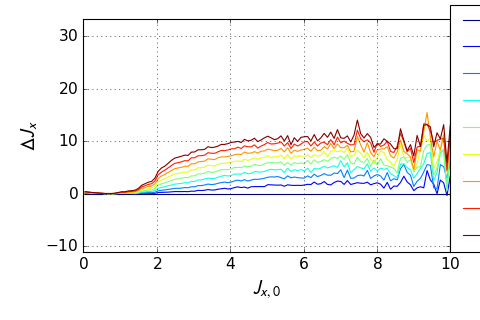

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


<IPython.core.display.Javascript object>


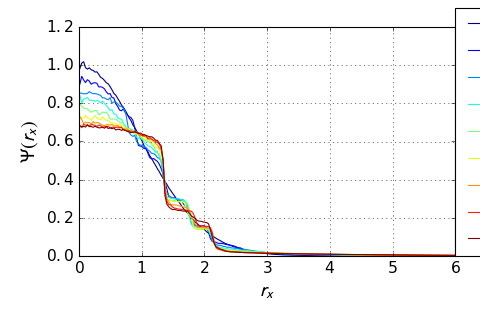

<IPython.core.display.Javascript object>


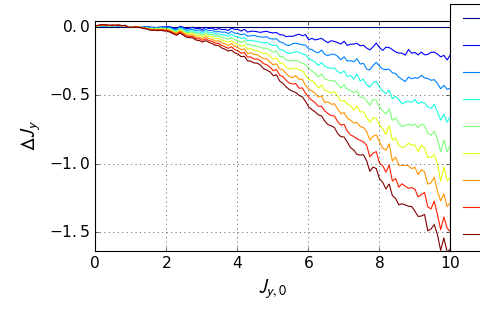

<IPython.core.display.Javascript object>


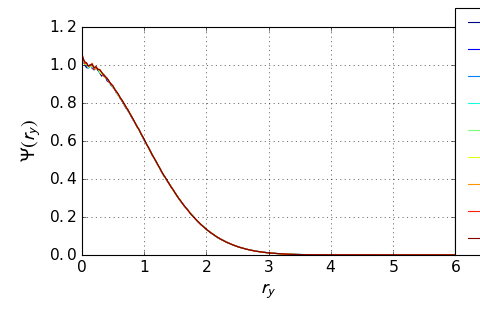

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [74]:



cmap = cm.get_cmap(None)
for i,turn_i in enumerate(output['turns']):
    c = cmap(turn_i/turnZ)
    lab_turn = '%dk turns'%(turn_i/1000)

    for plane in [0,1]:
        plt.figure(1+plane)
        x = edges_to_center(output['bins0Z']*output['jMax'])
        y = output[turn_i]['djAbs'][plane]
        plt.plot(x,y,c=c,label=lab_turn)
        plt.ylim(min(-np.max(y[x<6]),np.min(y[x<6])*3),np.max(y[x<6])*3)

        plt.figure(4+plane)
        x = edges_to_center(output['bins0Z']*output['rMax'])
        y = output[turn_i]['rAbs'][plane]/x
        plt.plot(x,y,c=c,label=lab_turn)

for plane in [0,1]:   
    xx = ['x','y'][plane]


    plt.figure(1+plane)
    x = edges_to_center(output['bins0Z']*output['jMax'])
    plt.legend(loc=(1,0))
    plt.ylabel(r'$\Delta J_%s$'%xx)
    plt.xlabel(r'$J_{%s,0}$'%xx)
    plt.grid(True)
    plt.xlim(0,10)
    plt.tight_layout()
    plt.savefig(plotdir +'/DDIST_%s_DACT_1D_dJ%s.png'%(folder,xx))

    plt.figure(4+plane)
    plt.legend(loc=(1,0))
    plt.ylabel(r'$\Psi(r_%s)$'%xx)
    plt.xlabel(r'$r_{%s}$'%xx)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plotdir +'/DDIST_%s_DIST_1D_rad%s.png'%(folder,xx))
